### Deep Neural Network for Image Classification: Application
    By the time you complete this notebook, you will have finished the last programming assignment of Week 4, and also the last programming assignment of Course 1! Go you!

    To build your cat/not-a-cat classifier, you'll use the functions from the previous assignment to build a deep network. Hopefully, you'll see an improvement in accuracy over your previous logistic regression implementation.

    After this assignment you will be able to:

        Build and train a deep L-layer neural network, and apply it to supervised learning

    Let's get started!

##### Table of Contents
    1 - Packages
    2 - Load and Process the Dataset
    3 - Model Architecture
        3.1 - 2-layer Neural Network
        3.2 - L-layer Deep Neural Network
        3.3 - General Methodology
    4 - Two-layer Neural Network
        Exercise 1 - two_layer_model
            4.1 - Train the model
    5 - L-layer Neural Network
        Exercise 2 - L_layer_model
            5.1 - Train the model
    6 - Results Analysis
    7 - Test with your own image (optional/ungraded exercise)

In [443]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import h5py
import copy
import scipy
from scipy import ndimage


%matplotlib inline
np.random.seed(1)

plt.rcParams["figure.figsize"] = (5.0, 4.0)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

#### 2 - Load and Process the Dataset
    You'll be using the same "Cat vs non-Cat" dataset as in "Logistic Regression as a Neural Network" (Assignment 2). The model you built back then had 70% test accuracy on classifying cat vs non-cat images. Hopefully, your new model will perform even better!

    Problem Statement: You are given a dataset ("data.h5") containing: 
    - a training set of m_train images labelled as cat (1) or non-cat (0) 
    - a test set of m_test images labelled as cat and non-cat 
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

    Let's get more familiar with the dataset. Load the data by running the cell below.

In [444]:
def load_data():
    train_data = h5py.File("./data/train_catvnoncat.h5", "r")
    test_data = h5py.File("./data/test_catvnoncat.h5", "r")
    
    train_X_orig = np.array(train_data["train_set_x"])
    train_Y_orig = np.array(train_data["train_set_y"])
    train_Y_orig = train_Y_orig.reshape(1, -1)
    
    test_X_orig = np.array(test_data["test_set_x"])
    test_Y_orig = np.array(test_data["test_set_y"])
    test_Y_orig = test_Y_orig.reshape(1, -1)
    
    classes = list(test_data["list_classes"])
    
    return (train_X_orig, train_Y_orig, test_X_orig, test_Y_orig, classes)
    
train_X_orig, train_Y_orig, test_X_orig, test_Y_orig, classes = load_data()

In [445]:
#Descriptive stats - explore the dataset
m_train = train_X_orig.shape[0]
m_test = test_X_orig.shape[0]
num_px = train_X_orig.shape[1]

print(train_X_orig.shape)
print(train_Y_orig.shape)
print(test_X_orig.shape)
print(test_Y_orig.shape)
print(list(classes))

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")

(209, 64, 64, 3)
(1, 209)
(50, 64, 64, 3)
(1, 50)
[b'non-cat', b'cat']
Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)


Y = 0. The image is a non-cat picture.


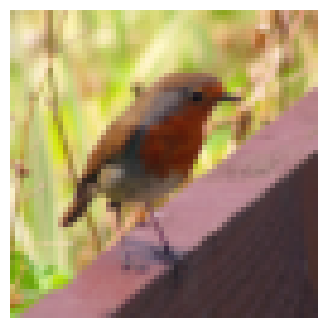

In [446]:
#visualize any image
index = 10
plt.imshow(train_X_orig[index])
print("Y = " + str(train_Y_orig[0, index]) +". The image is a " + classes[train_Y_orig[0, index]].decode("utf-8") +" picture.")
plt.axis("off")
plt.show()

    As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

In [447]:
#reshape the images
train_x_flatten = train_X_orig.reshape(m_train, -1).T
test_x_flatten = test_X_orig.reshape(m_test, -1).T

#standardize the images to have feature values between 0 and 1.
train_X = train_x_flatten / 255.0
test_X = test_x_flatten / 255.0

print ("train_x's shape: " + str(train_X.shape))
print ("test_x's shape: " + str(test_X.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


Note: 12288 equals 64x64x3, which is the size of one reshaped image vector.

#### 3 - Model Architecture

###### 3.1 - 2-layer Neural Network
    Now that you're familiar with the dataset, it's time to build a deep neural network to distinguish cat images from non-cat images!

    You're going to build two different models:

                A 2-layer neural network
                An L-layer deep neural network

    Then, you'll compare the performance of these models, and try out some different values for L.

    Let's look at the two architectures:
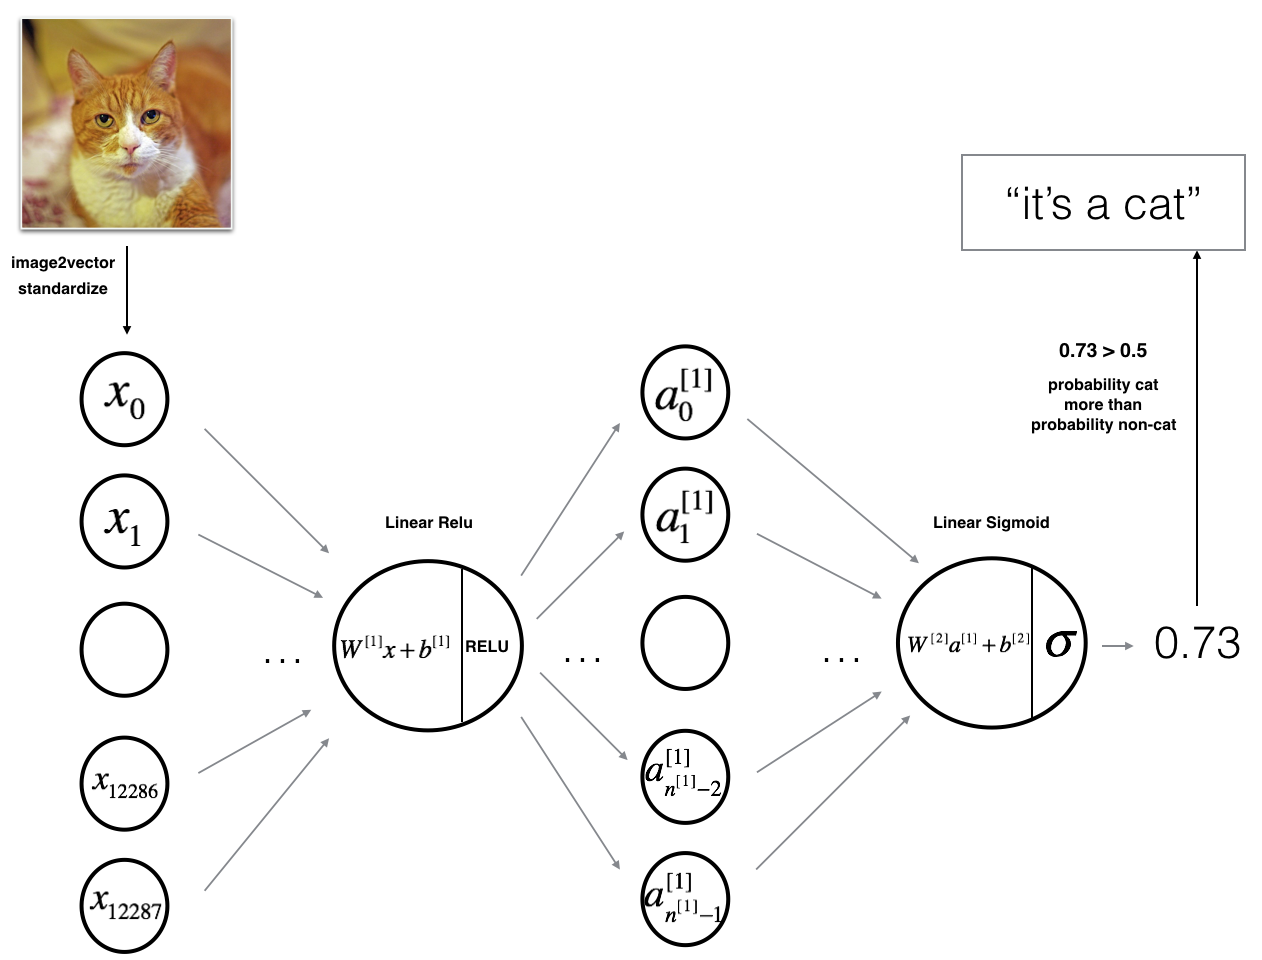

Figure 2: 2-layer neural network.

    The model can be summarized as: INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT.
    
**Detailed Architecture of Figure 2:**

- The input is a (64,64,3) image which is flattened to a vector of size (12288, 1).
- The corresponding vector: ${[x^0, x^1, .. x^12287]}^T$ is then multiplied by the weight matrix $W^{[1]}$of size ($n^{[1]}$, 12288).
- Then, add a bias term and take its relu to get the following vector: ${[a_0^{[1]}, a_1^{[1]}, .. a_{n^{1}-1}^{[1]}]}^T$.
- Multiply the resulting vector by $W^{[2]}$and add the intercept (bias).
- Finally, take the sigmoid of the result. If it's greater than 0.5, classify it as a cat.


#### 3.2 - L-layer Deep Neural Network
    It's pretty difficult to represent an L-layer deep neural network using the above representation. However, here is a simplified network representation:
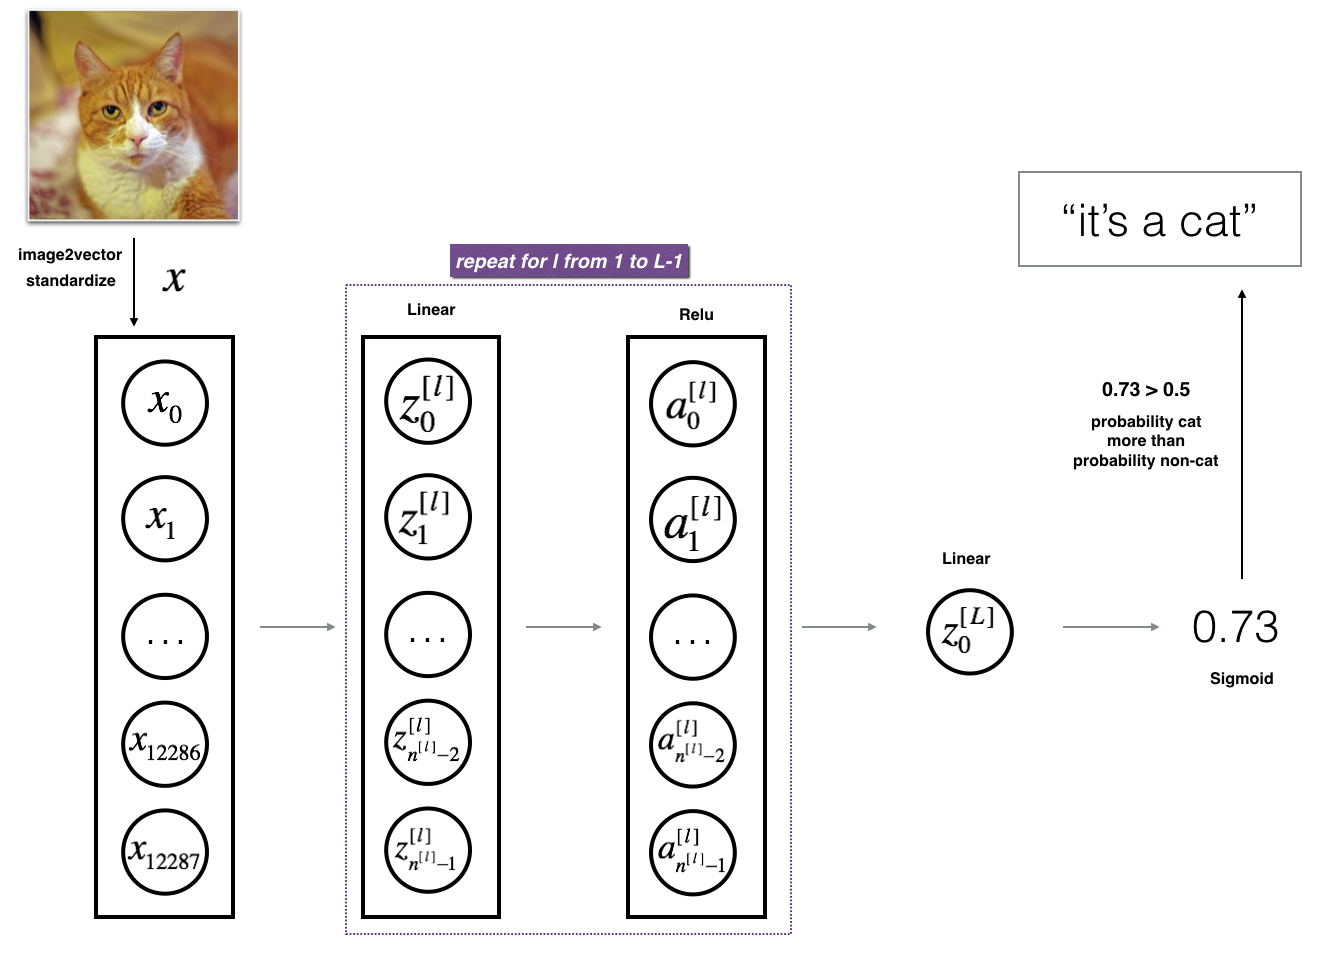
Figure 3: L-layer neural network.

The model can be summarized as: [LINEAR -> RELU] x (L-1) -> LINEAR -> SIGMOID

**Detailed Architecture of Figure 3:**

- The input is a (64, 64, 3) image which is flattened to a vector of size (12288, 1).
- The corresponding vector: ${[x^0, x^1, .. x^12287]}^T$ is then multiplied by the weight matrix $W^{[l]}$ and then you add the intercept $b^{[l]}$. The result is called the linear unit.
- Next, take the relu of the linear unit. This process could be repeated several times for each ($W^{[l]}, b^{[1]}$) depending on the model architecture.
- Finally, take the sigmoid of the final linear unit. If it is greater than 0.5, classify it as a cat.

#### 3.3 - General Methodology
    As usual, you'll follow the Deep Learning methodology to build the model:

       - Initialize parameters / Define hyperparameters
       - Loop for num_iterations: 
           - a. Forward propagation 
           - b. Compute cost function 
           - c. Backward propagation 
           - d. Update parameters (using parameters, and grads from backprop)
       - Use trained parameters to predict labels
       - Now go ahead and implement those two models!


#### 4 - Two-layer Neural Network

##### Exercise 1 - two_layer_model
    Use the helper functions you have implemented in the previous assignment to build a 2-layer neural network with the following structure: LINEAR -> RELU -> LINEAR -> SIGMOID. The functions and their inputs are:

    def initialize_parameters(n_x, n_h, n_y):
        ...
        return parameters 
        
    def linear_activation_forward(A_prev, W, b, activation):
        ...
        return A, cache
    def compute_cost(AL, Y):
        ...
        return cost
        
    def linear_activation_backward(dA, cache, activation):
        ...
        return dA_prev, dW, db
        
    def update_parameters(parameters, grads, learning_rate):
        ...
        return parameters

In [448]:
##Intialization of 2 layered NN parameters
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    np.random.seed(1)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    params = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return params

In [449]:
#Intialization of deep L parameters
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    np.random.seed(1)
    params = {}
    for i in range(1, len(layer_dims)):  
        params[f"W{i}"] = np.random.randn(layer_dims[i], layer_dims[i-1]) / np.sqrt(layer_dims[i-1]) #0.01  #Xavier/Glorot Initialization
        params[f"b{i}"] = np.zeros((layer_dims[i], 1))
        assert(params["W"+str(i)].shape == (layer_dims[i], layer_dims[i-1])), "Wrong initialization shapes of W "
        assert(params["b"+str(i)].shape == (layer_dims[i], 1)), "Wrong initialization shapes of b"
    return params

In [450]:
#Forward propagation
def linear_forward(A, W, b): 
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    assert(W.shape[1]==A.shape[0]), f"Wrong shapes. W.shape[1] and A.shape[0] are not matching"
    Z = np.dot(W, A) + b                                               #(n_h, n) (n, m) + (n_h, 1) = (n_h, m)
    cache = (A, W, b) #tuple #note A is previous layer activation and it is useful for input of dW_l from dZ_l during backprop
    assert(Z.shape==(W.shape[0], A.shape[1])), f"Wrong shape for Z"
    return Z, cache

#activation functions
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    activation_cache = Z 
    
    return A, activation_cache

def relu(Z):
    A = np.maximum(0, Z)
    activation_cache = Z 
    return A, activation_cache

def linear_activation_forward(A_prev, W, b, activation_name):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation_name -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation_name == "sigmoid":
        A, activation_cache = sigmoid(Z)
        
    if activation_name == "relu":
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)
    return A, cache

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """
    A = X
    L = len(parameters) // 2 #getting the length from parameters as it contains W1, b1 of each layer using floor division to get int val as o/p
    caches = []
    
    # The for loop starts at 1 because layer 0 is the input, note loop executes till L-1, as it is right exclusive
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters[f"W{l}"], parameters[f"b{l}"], activation_name="relu")
        caches.append(cache)
    
    #last layer
    AL, cache = linear_activation_forward(A, parameters[f"W{L}"], parameters[f"b{L}"], activation_name="sigmoid")
    caches.append(cache)
    return AL, caches

In [451]:
#Cost
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]
    J = np.dot(Y, np.log(AL.T)) + np.dot((1-Y), np.log(1-AL.T))                #1, m m, 1
    #J = -(np.sum(Y * np.log(AL) + (1-Y) * np.log(1 - AL))) / m
    cost = - J / m
    cost = np.squeeze(cost)
    
    return cost

In [452]:
#Backward Propagation
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)   
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW_l -- Gradient of the cost with respect to W (current layer l), same shape as W
    db_l -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W_l, b_l = cache
    m = A_prev.shape[1]
    dZ_l = dZ
    
    dW_l = np.dot(dZ_l, A_prev.T) / m                         #(nl, m) (m, na) = (nl, na)
    db_l = np.sum(dZ_l, axis=1, keepdims=True) / m            #(n_l, 1)
    dA_prev = np.dot(W_l.T, dZ_l)                             # (na, nl) (nl, m) = (na, m)
    
    return dA_prev, dW_l, db_l

def sigmoid_backward(dA, Z):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    Z -- 'cache' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    A, _ = sigmoid(Z)
    g_d_z = A * (1 - A) #derivative of dA/dZ = g'(Z)
    dZ = dA * g_d_z
    assert (dZ.shape == Z.shape)
    return dZ

def relu_backward(dA, Z):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    Z -- 'cache' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    dZ[Z <= 0] = 0
    assert(dZ.shape == Z.shape)
    return dZ

def linear_activation_backward(dA, cache, activation_name="relu"):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation_name -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, Z_l = cache  #A_prev, W_l, b_l = linear cache, activation_cache contains Z_l
    dA_l = dA #for representation
        
    if activation_name == "relu":
        dZ_l = relu_backward(dA_l, Z_l)
        
    if activation_name == "sigmoid":
        dZ_l = sigmoid_backward(dA_l, Z_l)
        
    dA_prev, dW_l, db_l = linear_backward(dZ_l, linear_cache)
    return dA_prev, dW_l, db_l


def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    
    L = len(caches) #no. of layers
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    grads = {} 
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) 
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    dA_prev, dW, db = linear_activation_backward(dAL, current_cache, activation_name="sigmoid")
    grads[f"dW{L}"] = dW 
    grads[f"db{L}"] = db
    grads[f"dA{L-1}"] = dA_prev
    
    # Loop from l=L-2 to l=0 # Eg: L = 4, L-1 = 3, range(3) = 0 1 2, reversed(range(3))= 2 1 0
    for l in reversed(range(L-1)): 
        current_cache = caches[l]
        dA_prev, dW_l, db_l  = linear_activation_backward(dA_prev, current_cache, activation_name="relu")
        grads[f"dW{l+1}"] = dW_l     
        grads[f"db{l+1}"] = db_l
        grads[f"dA{l}"] = dA_prev
    return grads

In [453]:
#Optimization - updating parameters
def update_parameters(params, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    params -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    L = len(params) // 2 # number of layers in the neural network
    params = params.copy()
    
    for l in range(L):
        params[f"W{l+1}"] = params[f"W{l+1}"] - learning_rate * grads[f"dW{l+1}"]
        params[f"b{l+1}"] = params[f"b{l+1}"] - learning_rate * grads[f"db{l+1}"]
        
    return params

In [454]:
#Plot the learning curve
def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel("cost")
    plt.xlabel("iterations (per hundreds)")
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

In [455]:
#Predictions
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1, m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0, i] > 0.5:
            p[0, i] = 1
        else:
            p[0, i] = 0
    
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [456]:
#2 Layer NN model
def two_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    np.random.seed(1)
    params = initialize_parameters(*layers_dims)
    
    W1, b1, W2, b2 = params.values()
    grads = {}
    costs = []
    # Loop (gradient descent)
    for i in range(num_iterations):
        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID
        A1, cache1 = linear_activation_forward(X, W1, b1, activation_name="relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation_name="sigmoid")
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide((1-Y), (1-A2)))
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation_name="sigmoid")
        dA0, dW1, db1  = linear_activation_backward(dA1, cache1, activation_name="relu")
        
        grads["dW1"] = dW1
        grads["db1"] = db1
        grads["dW2"] = dW2
        grads["db2"] = db2
        
        # Update parameters - optimization
        params = update_parameters(params, grads, learning_rate)
        W1 = params["W1"]
        b1 = params["b1"]
        W2 = params["W2"]
        b2 = params["b2"]
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations-1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
            
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
            
    return params, costs

In [457]:
#test our two_layer_model()

#Hyperparameters
n_x = train_X.shape[0]
n_h = 7
n_y = train_Y_orig.shape[0]
layers_dims = (n_x, n_h, n_y) #  2-layer model

parameters, costs = two_layer_model(train_X, train_Y_orig, layers_dims, num_iterations=2, print_cost=False)

print("Cost after first iteration: " + str(costs[0]))

Cost after iteration 1: 0.6926114346158596
Cost after first iteration: 0.6930497356599891


#### 4.1 - Train the model
    If your code passed the previous cell, run the cell below to train your parameters.

    The cost should decrease on every iteration.

    It may take up to 5 minutes to run 2500 iterations.

In [458]:
#2-layer Model training
#Hyperparameters
n_x = train_X.shape[0]
n_h = 7
n_y = train_Y_orig.shape[0]
layers_dims = (n_x, n_h, n_y) #  2-layer model

final_params, costs = two_layer_model(train_X, train_Y_orig, layers_dims, num_iterations=2500, print_cost=True)

Cost after iteration 0: 0.6930497356599891
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605748
Cost after iteration 500: 0.515830477276473
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.40079775362038894
Cost after iteration 900: 0.35807050113237987
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.30527536361962637
Cost after iteration 1200: 0.2749137728213017
Cost after iteration 1300: 0.24681768210614838
Cost after iteration 1400: 0.19850735037466094
Cost after iteration 1500: 0.1744831811255665
Cost after iteration 1600: 0.17080762978096348
Cost after iteration 1700: 0.11306524562164726
Cost after iteration 1800: 0.09629426845937147
Cost after iteration 1900: 0.08342617959726856
Cost after iteration 2000: 0.0743907870431908
Cost after iteration 2100: 0.066307481

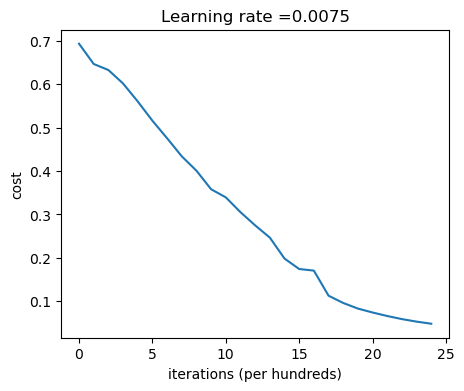

In [461]:
#0.04421498215868959
plot_costs(costs)

In [463]:
#predictions using 2 Layer model - training accuracy
predictions_train = predict(train_X, train_Y_orig, final_params)

Accuracy: 0.9999999999999998


In [464]:
##predictions using 2 Layer model - test accuracy
predictions_test = predict(test_X, test_Y_orig, final_params)

Accuracy: 0.72



    Congratulations! It seems that your 2-layer neural network has better performance (72%) than the logistic regression implementation (70%, assignment week 2). Let's see if you can do even better with an L-layer model.
    
    Note: You may notice that running the model on fewer iterations (say 1500) gives better accuracy on the test set. This is called "early stopping" and you'll hear more about it in the next course. Early stopping is a way to prevent overfitting.

#### 5 - L-layer Neural Network

##### Exercise 2 - L_layer_model
    Use the helper functions you implemented previously to build an L-layer neural network with the following structure: [LINEAR -> RELU] x (L-1) -> LINEAR -> SIGMOID. The functions and their inputs are:

    def initialize_parameters_deep(layers_dims):
        ...
        return parameters 
    def L_model_forward(X, parameters):
        ...
        return AL, caches
    def compute_cost(AL, Y):
        ...
        return cost
    def L_model_backward(AL, Y, caches):
        ...
        return grads
    def update_parameters(parameters, grads, learning_rate):
        ...
        return parameters

In [465]:
#L Layer NN model
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    np.random.seed(1)
    params = initialize_parameters_deep(layers_dims)
    costs = []
    # Loop (gradient descent)
    for i in range(num_iterations):
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID
        AL, caches = L_model_forward(X, parameters=params)
        # Compute cost
        cost = compute_cost(AL, Y)
        # Backward propagation
        grads = L_model_backward(AL, Y, caches)
        # Update parameters - optimization
        params = update_parameters(params, grads, learning_rate)
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations-1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
            
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
            
    return params, costs

In [466]:
#test our L_layer_model()

#Hyperparameters
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model
parameters, costs = L_layer_model(train_X, train_Y_orig, layers_dims, num_iterations=1, print_cost=False)

print("Cost after first iteration: " + str(costs[0])) #0.7717493284237686


Cost after iteration 0: 0.7717493284237686
Cost after first iteration: 0.7717493284237686


In [467]:
#Hyperparameters
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model
#L-layer Model training
final_params, costs = L_layer_model(train_X, train_Y_orig, layers_dims, num_iterations=2500, print_cost=True)

#0.088439943441702

Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6720534400822915
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101356
Cost after iteration 400: 0.5670473268366111
Cost after iteration 500: 0.5401376634547799
Cost after iteration 600: 0.5279299569455267
Cost after iteration 700: 0.46547737717668514
Cost after iteration 800: 0.369125852495928
Cost after iteration 900: 0.39174697434805356
Cost after iteration 1000: 0.3151869888600616
Cost after iteration 1100: 0.2726998441789385
Cost after iteration 1200: 0.2374185340026814
Cost after iteration 1300: 0.19960120532208647
Cost after iteration 1400: 0.18926300388463305
Cost after iteration 1500: 0.1611885466582775
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.13777487812972944
Cost after iteration 1800: 0.12974017549190123
Cost after iteration 1900: 0.12122535068005215
Cost after iteration 2000: 0.11382060668633708
Cost after iteration 2100: 0.107839285

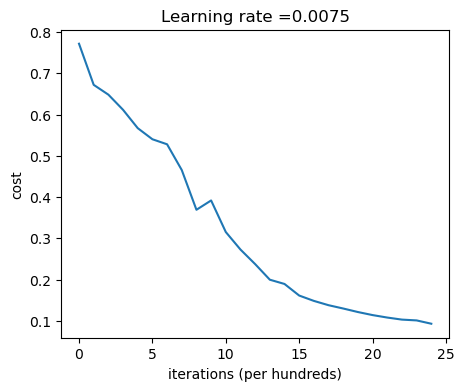

In [468]:
plot_costs(costs, learning_rate=0.0075)

In [469]:
#predictions using L Layer model - training accuracy
predictions_train = predict(train_X, train_Y_orig, final_params) #0.9856459330143539

Accuracy: 0.9856459330143539


In [470]:
#predictions using L Layer model - test accuracy
predictions_test = predict(test_X, test_Y_orig, final_params)

Accuracy: 0.8


    Congrats! It seems that your 4-layer neural network has better performance (80%) than your 2-layer neural network (72%) on the same test set.

    This is pretty good performance for this task. Nice job!

    In the next course on "Improving deep neural networks," you'll be able to obtain even higher accuracy by systematically searching for better hyperparameters: learning_rate, layers_dims, or num_iterations, for example.


#### 6 - Results Analysis
    First, take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images.

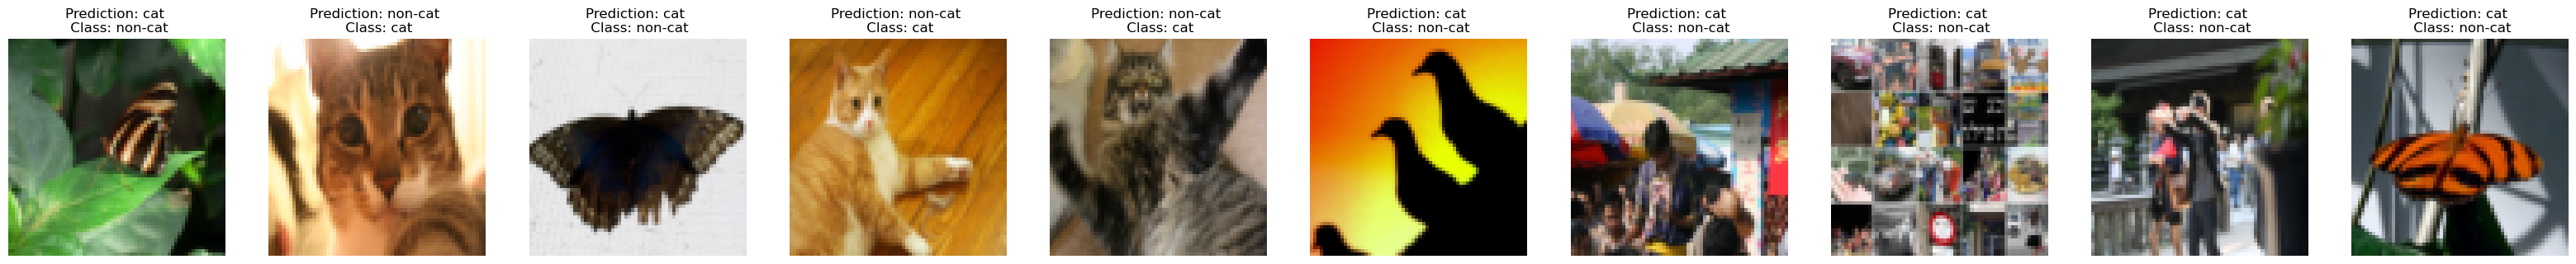

In [472]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

print_mislabeled_images(classes, test_X, test_Y_orig, predictions_test)

In [473]:
a = predictions_test + test_Y_orig
print(predictions_test.shape)
print(test_Y_orig.shape)
print(a.shape)
mislabeled_indices = np.where(a == 1)
print(len(mislabeled_indices))
print(mislabeled_indices[0])
print(print(mislabeled_indices[0]))

(1, 50)
(1, 50)
(1, 50)
2
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
None


In [474]:
predictions_test

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
        0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 0.]])

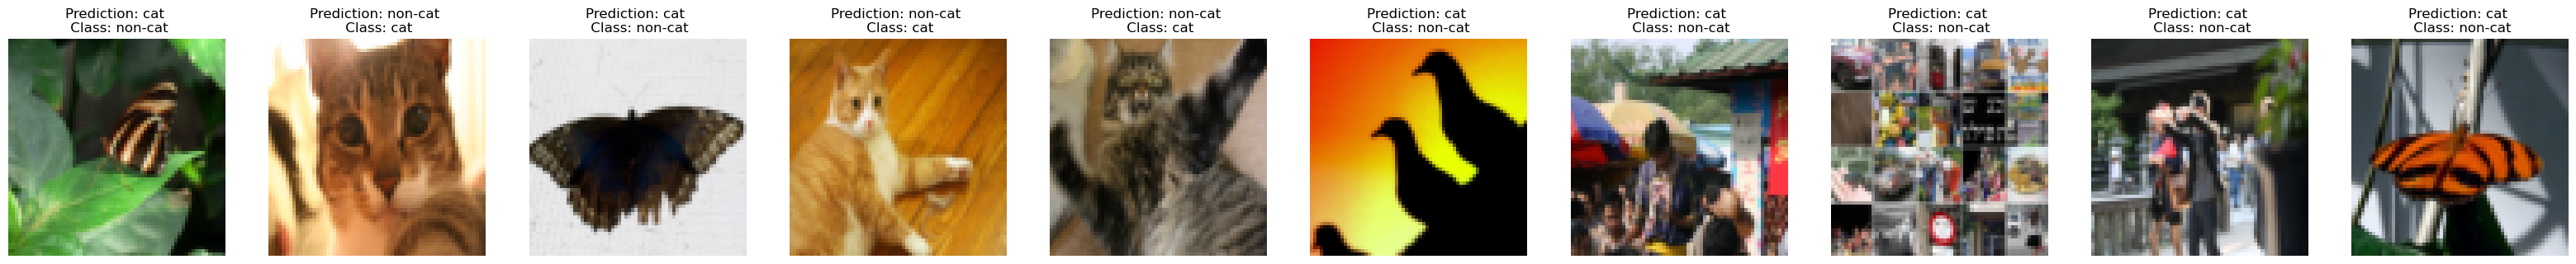

In [475]:
#get the mislabeled examples
mask = np.where(predictions_test[0] != test_Y_orig[0])
plt.rcParams["figure.figsize"] = (40.0, 40.0) # set default size of plots
for i, mislabidx in enumerate(mask[0]):
    plt.subplot(2, len(mask[0]), i+1)
    plt.imshow(test_X[:, mislabidx].reshape(num_px, num_px, 3), interpolation="nearest")
    plt.axis("off")
    plt.title("Prediction: " + classes[int(predictions_test[0, mislabidx])].decode("utf-8") + " \n Class: " + classes[test_Y_orig[0, mislabidx]].decode("utf-8"))
plt.show()

A few types of images the model tends to do poorly on include:

    Cat body in an unusual position
    Cat appears against a background of a similar color
    Unusual cat color and species
    Camera Angle
    Brightness of the picture
    Scale variation (cat is very large or small in image)
    
### Congratulations on finishing this assignment!
    
    You just built and trained a deep L-layer neural network, and applied it in order to distinguish cats from non-cats, a very serious and important task in deep learning. ;)

    By now, you've also completed all the assignments for Course 1 in the Deep Learning Specialization. Amazing work! If you'd like to test out how closely you resemble a cat yourself, there's an optional ungraded exercise below, where you can test your own image.

    Great work and hope to see you in the next course!


#### 7 - Test with your own image (optional/ungraded exercise)
    From this point, if you so choose, you can use your own image to test the output of your model. To do that follow these steps:

    Give the file name of your image in the below code
    Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

Accuracy: 0.0
y= 0.0, your L-layer model predicts a "non-cat"


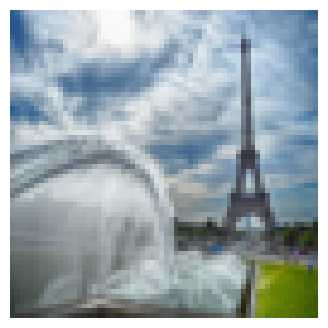

In [238]:
my_image = "towerimage2.jpg"
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)

fname = "./images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.rcParams["figure.figsize"] = (5.0, 4.0)
plt.imshow(image)
plt.axis("off")
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, final_params)

print ("y= " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + 
       classes[int(np.squeeze(my_predicted_image))].decode("utf-8") + "\"")

Accuracy: 0.0
y= 0.0, your L-layer model predicts a "non-cat"


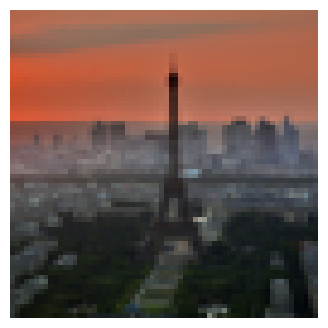

In [239]:
my_image = "tower image.jpg"
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)

fname = "./images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
plt.axis("off")
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, final_params)

print ("y= " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + 
       classes[int(np.squeeze(my_predicted_image))].decode("utf-8") + "\"")

Accuracy: 1.0
y= 1.0, your L-layer model predicts a "cat"


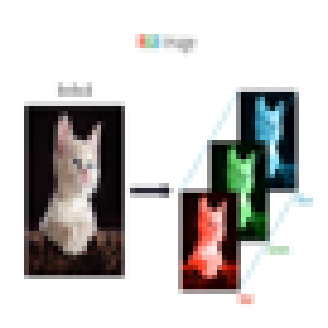

In [240]:
my_image = "rgb cat image.jpeg"
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)

fname = "./images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
plt.axis("off")
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, final_params)

print ("y= " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + 
       classes[int(np.squeeze(my_predicted_image))].decode("utf-8") + "\"")

### Some experiments on test your own images
https://community.deeplearning.ai/t/some-experiments-with-the-cat-recognition-assignment-c1w4a2/34124/3
    
    It is frequently observed by students using the “Test with Your Own Image” section of the C1W4 Application Assignment with their own uploaded images that even the 4 layer model that we trained doesn’t do very well on new images, even though it has 80% accuracy on the test set here. It turns out that the datasets we have here are quite small compared to the sizes required to get good “generalizable” performance on an image recognition task like this. As a comparison, the Kaggle “Cats and Dogs” dataset 1 has 25k images. It’s clear that the limitations of the online environment here required them to come up with pretty small datasets, so it occurred to me to flip the question around: how did they get such good performance with such a small dataset? Is there something special about the dataset that they are using here that allows them to get such relatively good performance with so few input data samples?

    The first step is to do a little error analysis on the results. For all the experiments here, I increased the number of iterations to 3000, but used the same 4 layer network and the learning rate of 0.0075 that they used for the “official” results. Here’s the result from that run with the original dataset analyzed with a little extra code to compute the numbers of false positives and false negatives on the test set:
    
    Lets perform error analysis and experiment

In [476]:
#Running the L-layer model with usual 4 layers but with 3000 iterations
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model
params, costs = L_layer_model(train_X, train_Y_orig, layers_dims, num_iterations=3000, print_cost=True)
pred_train = predict(train_X, train_Y_orig, params)
pred_test = predict(test_X, test_Y_orig, params)

Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6720534400822915
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101356
Cost after iteration 400: 0.5670473268366111
Cost after iteration 500: 0.5401376634547799
Cost after iteration 600: 0.5279299569455267
Cost after iteration 700: 0.46547737717668514
Cost after iteration 800: 0.369125852495928
Cost after iteration 900: 0.39174697434805356
Cost after iteration 1000: 0.3151869888600616
Cost after iteration 1100: 0.2726998441789385
Cost after iteration 1200: 0.2374185340026814
Cost after iteration 1300: 0.19960120532208647
Cost after iteration 1400: 0.18926300388463305
Cost after iteration 1500: 0.1611885466582775
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.13777487812972944
Cost after iteration 1800: 0.12974017549190123
Cost after iteration 1900: 0.12122535068005215
Cost after iteration 2000: 0.11382060668633708
Cost after iteration 2100: 0.107839285

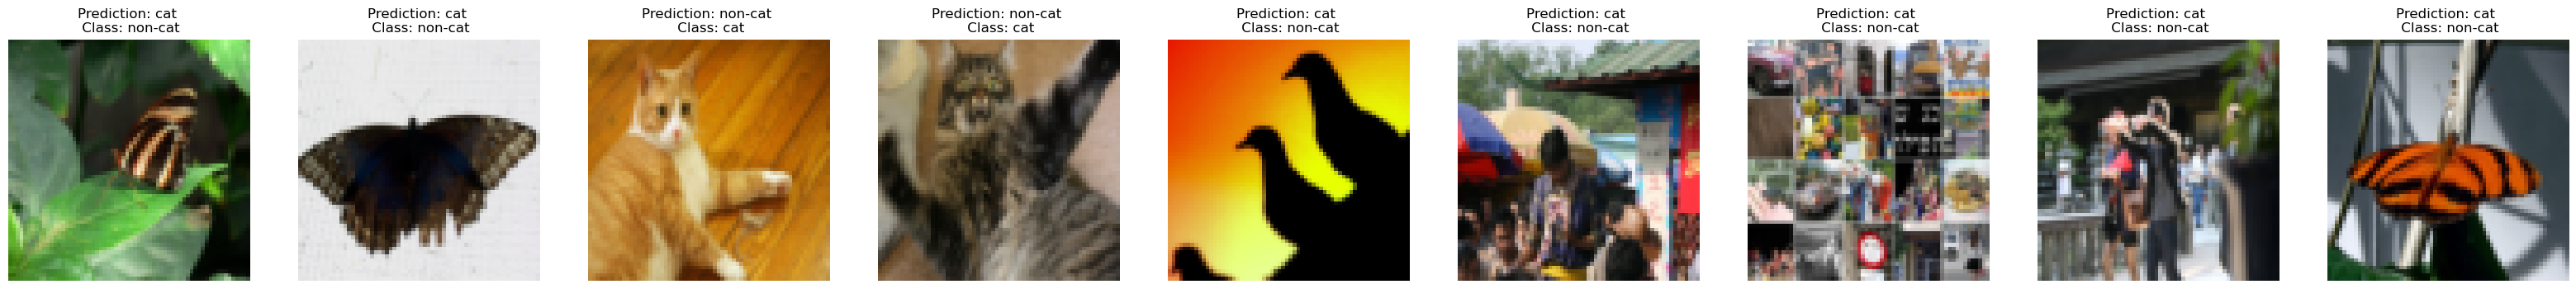

In [508]:
print_mislabeled_images(classes, test_X, test_Y_orig, pred_test)

In [478]:
print(f"Mislabelled Error count: {np.sum(pred_test != test_Y_orig)}")
print(f"Test False positives: {np.sum(pred_test[test_Y_orig == 0] == 1)}")
print(f"Test False Negatives: {np.sum(pred_test[test_Y_orig == 1] == 0)}")

Mislabelled Error count: 9
Test False positives: 7
Test False Negatives: 2


    So you can see that most of the errors on the test set are false positives, meaning that the model seems to be a bit “yes happy”.

    The next thing to look at is the balance of “cat” (yes) samples versus “non-cat” (no) samples in the two datasets. We already know that training set has 209 samples and the test set has 50 samples. Let’s see how many of each are “true” samples:

In [483]:
print(f"Train Positive samples sum(train_y) = {np.sum(train_Y_orig)}")
print(f"Test Positive samples sum(test_y) = {np.sum(test_Y_orig)}")
print(f"Positive Training samples ratio: {np.sum(train_Y_orig) / train_Y_orig.shape[1]:.2f} %")
print(f"Postivie Test samples ratio: {np.sum(test_Y_orig) / test_Y_orig.shape[1]:.2f} %")

Train Positive samples sum(train_y) = 72
Test Positive samples sum(test_y) = 33
Positive Training samples ratio: 0.34 %
Postivie Test samples ratio: 0.66 %


    Interesting! The training set has only 34% cats, but the test set is 66% cats, which makes things seem a bit “unbalanced”. But maybe that’s a good strategy if they know that the learned model is “yes happy”. So the next question is whether that unbalance is important or not. One way to experiment with that would be to trade positive samples from the test set with negative samples from the training set to make the two look a bit more similar. Unfortunately because of the smaller size of the test set, we don’t have enough positive samples to get the training set to 50/50 without completely depleting the positive examples in the test set. The reason for trading entries rather than just moving them is to try to control the number of variables that we are changing in this scientific experiment. If we increase the size of the training set, then we can’t be sure whether it’s the balance change or the size change that made the difference.

    Here’s a block of code to trade the same number (numTrade) of positive images from the test set with the same number of negative images from the training set:

In [495]:
numTrade = 4

#first get the positive and negative examples from the training set
train_pos_X = train_X[:, np.squeeze(train_Y_orig == 1)]
train_pos_Y = np.ones((1, train_pos_X.shape[1]), dtype=int)
train_neg_X = train_X[:, np.squeeze(train_Y_orig == 0)]
train_neg_Y = np.zeros((1, train_neg_X.shape[1]), dtype="int")
print("Training data stats:")
print(train_pos_X.shape)
print(train_pos_Y.shape)
print(train_neg_X.shape)
print(train_neg_Y.shape)

#Next get the positive and negative examples from the test set
test_pos_X = test_X[:, np.squeeze(test_Y_orig == 1)]
test_pos_Y = np.ones((1, test_pos_X.shape[1]), dtype=int)
test_neg_X = test_X[:, np.squeeze(test_Y_orig == 0)]
test_neg_Y = np.zeros((1, test_neg_X.shape[1]), dtype="int")
print("\nTest data stats:")
print(test_pos_X.shape)
print(test_pos_Y.shape)
print(test_neg_X.shape)
print(test_neg_Y.shape)

Training data stats:
(12288, 72)
(1, 72)
(12288, 137)
(1, 137)

Test data stats:
(12288, 33)
(1, 33)
(12288, 17)
(1, 17)


In [504]:
#Now Permute the negative samples randomly from train set before we pick the ones to trade
perm = np.squeeze(np.random.permutation(train_neg_X.shape[1]))
# print(perm)
train_neg_X_perm = train_neg_X[:, perm]
#Now get the numTrade i.w 4 samples from randomly sampled train negative samples
train_neg_X_trade = train_neg_X_perm[:, 0:numTrade]
train_neg_Y_trade = np.zeros((1, train_neg_X_trade.shape[1]), dtype = 'int64')
train_neg_X_keep = train_neg_X_perm[:, numTrade:]
train_neg_Y_keep = np.zeros((1, train_neg_X_keep.shape[1]), dtype = 'int64')

#Now Permute the positive samples randomly from test set  before we pick the ones to trade
perm = np.squeeze(np.random.permutation(test_pos_X.shape[1]))
test_pos_X_perm = test_pos_X[:, perm]
#Now get the numTrade i.w 4 samples from randomly sampled test positive samples
test_pos_X_trade = test_pos_X_perm[:, 0:numTrade]
test_pos_Y_trade = np.ones((1, test_pos_X_trade.shape[1]), dtype = 'int64')
test_pos_X_keep = test_pos_X_perm[:, numTrade:]
test_pos_Y_keep = np.ones((1, test_pos_X_keep.shape[1]), dtype = 'int64')

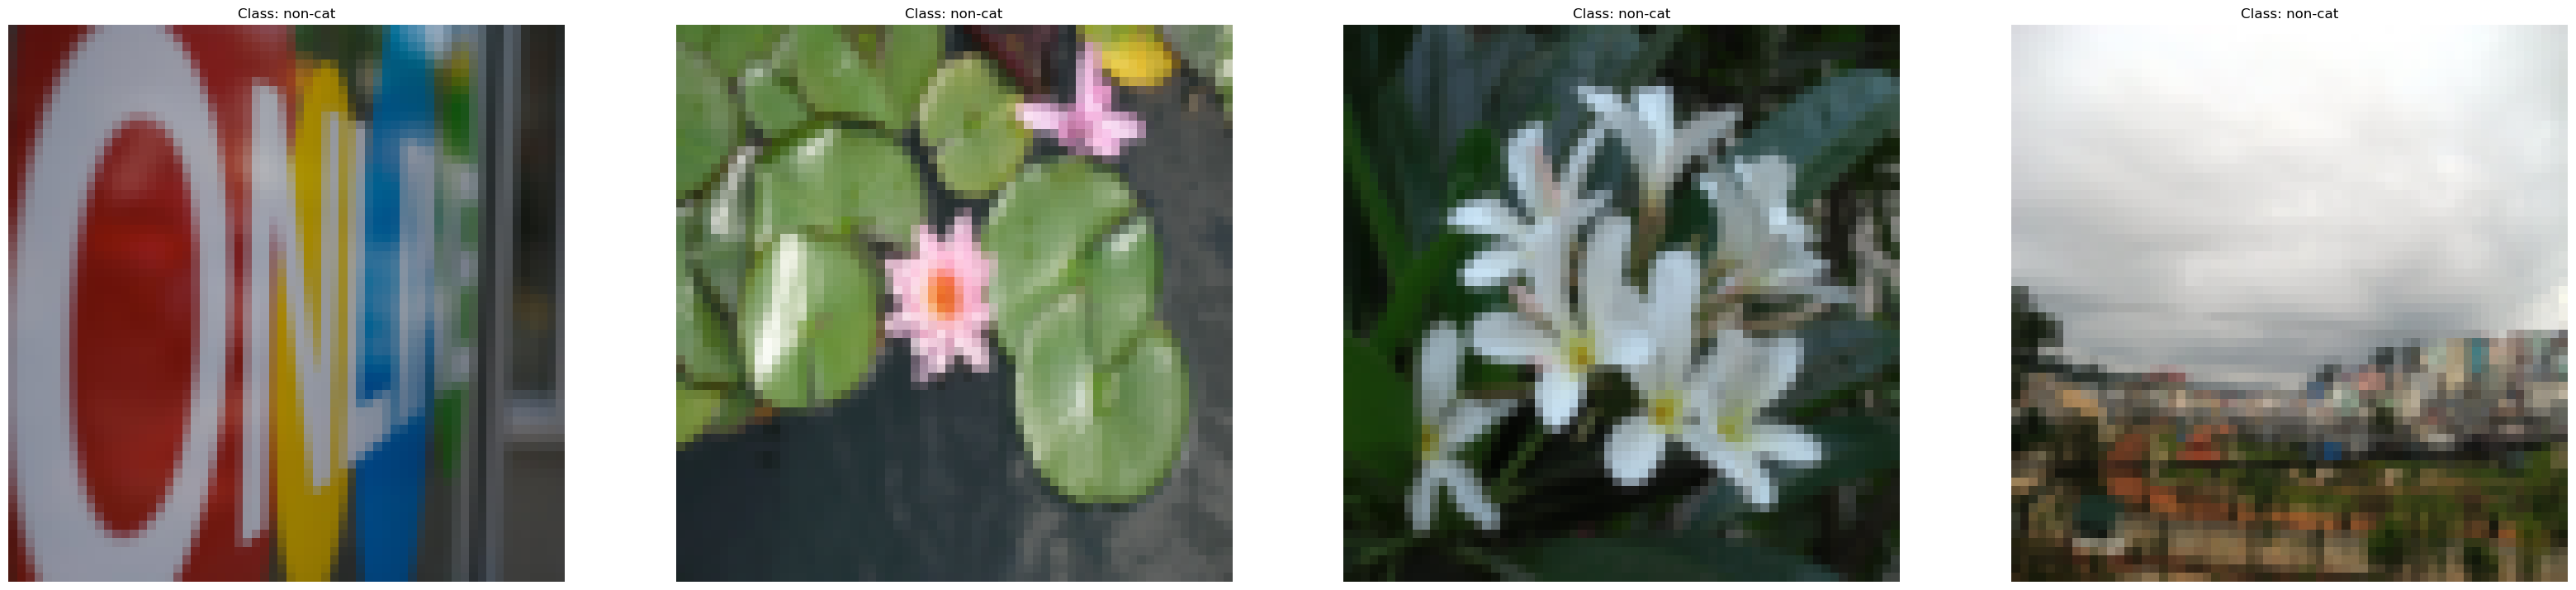

In [505]:
def print_these_images(classes, X, y):
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = X.shape[1]
    for ii in range(num_images):
        plt.subplot(2, num_images, ii + 1)
        plt.imshow(X[:, ii].reshape(64, 64, 3), interpolation='nearest')
        plt.axis('off')
        plt.title("Class: " + classes[y[0, ii]].decode("utf-8"))
    plt.show()
    
    
print_these_images(classes, train_neg_X_trade, train_neg_Y_trade)
#This block shows the images that are being traded. Here are the new negatives for the test set

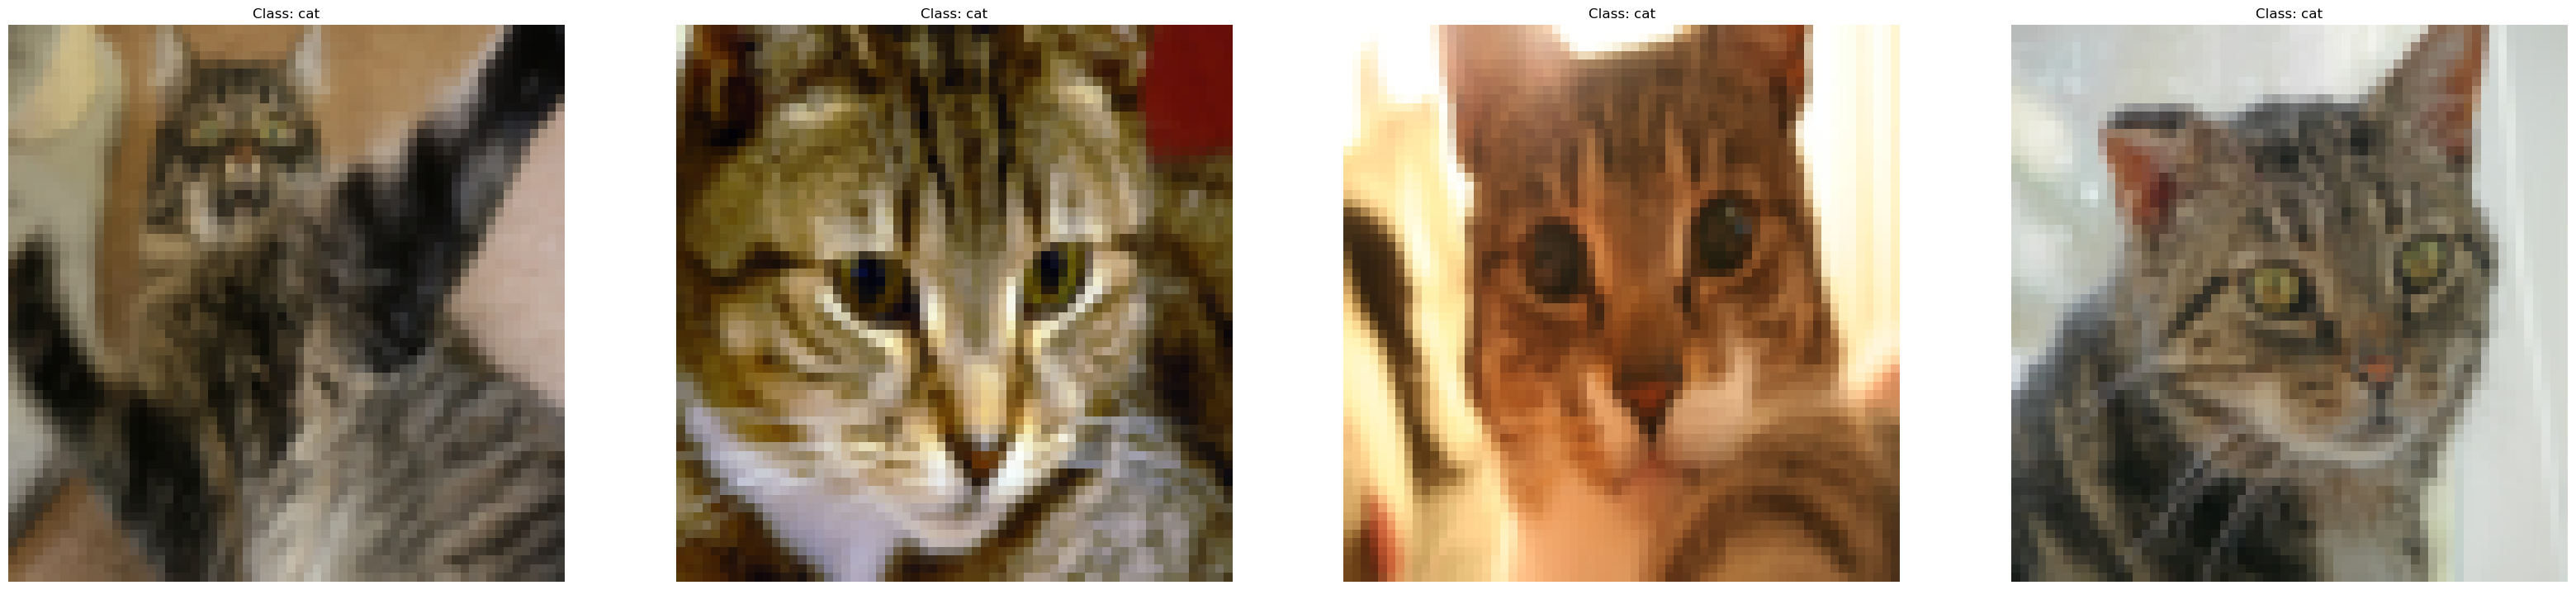

In [506]:
print_these_images(classes, test_pos_X_trade, test_pos_Y_trade)
#This block shows the images that are being traded. Here are the new positives for the training set

In [507]:
#Now concatenate the samples to get the balanced set
bal_train_x = np.concatenate((train_pos_X, test_pos_X_trade, train_neg_X_keep), axis=1)
bal_train_y = np.concatenate((train_pos_Y, test_pos_Y_trade, train_neg_Y_keep), axis=1)

bal_test_x = np.concatenate((test_pos_X_keep, test_neg_X, train_neg_X_trade), axis=1)
bal_test_y = np.concatenate((test_pos_Y_keep, test_neg_Y, train_neg_Y_trade), axis=1)

print(bal_train_x.shape)
print(bal_train_y.shape)
print(bal_test_x.shape)
print(bal_test_y.shape)

print(f"After rebalance positive samples: train = {np.sum(bal_train_y)}, test = {np.sum(bal_test_y)}")

(12288, 209)
(1, 209)
(12288, 50)
(1, 50)
After rebalance positive samples: train = 76, test = 29


    Before we start on the trading experiments, observe the output from the training run with the unmodified dataset of 3000 iterations.
    
    The two false negative cases have the cats in pretty strange positions. There doesn’t seem to be anything common to the false positives, except that a couple of them contain butterflies. 
    
    Ok, here’s the result of the first run with numTrade = 4 using this test block:

Cost after iteration 0: 0.7631360822349578
Cost after iteration 100: 0.6745980602077873
Cost after iteration 200: 0.6440887862939054
Cost after iteration 300: 0.5893499685119851
Cost after iteration 400: 0.5633330810139795
Cost after iteration 500: 0.5107295747431478
Cost after iteration 600: 0.4514475640336778
Cost after iteration 700: 0.353332005430836
Cost after iteration 800: 0.3073192452034798
Cost after iteration 900: 0.27767518789250173
Cost after iteration 1000: 0.22587630185766203
Cost after iteration 1100: 0.19740214684686797
Cost after iteration 1200: 0.17351469838311614
Cost after iteration 1300: 0.15459432083320537
Cost after iteration 1400: 0.13934273809918393
Cost after iteration 1500: 0.1263000118523458
Cost after iteration 1600: 0.11553248860277822
Cost after iteration 1700: 0.10715164935723875
Cost after iteration 1800: 0.10295323173870953
Cost after iteration 1900: 0.09120321067616516
Cost after iteration 2000: 0.08659748141818656
Cost after iteration 2100: 0.0793412

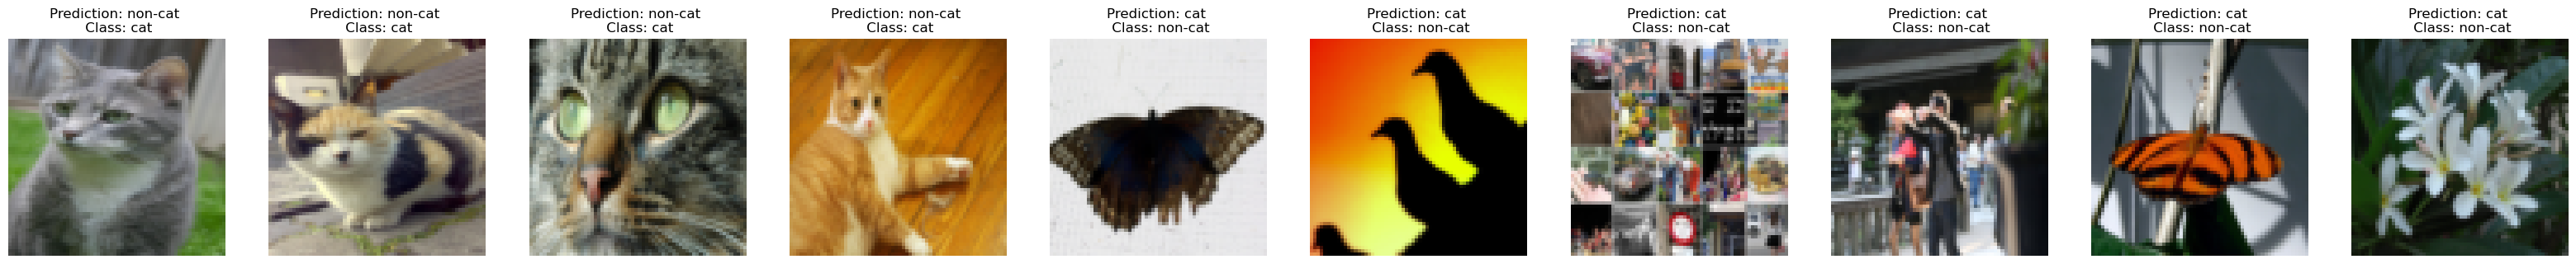

In [509]:
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model
parameters, costs = L_layer_model(bal_train_x, bal_train_y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=True)
bal_pred_train = predict(bal_train_x, bal_train_y, parameters)
bal_pred_test = predict(bal_test_x, bal_test_y, parameters)
print(f"positive samples: train = {np.sum(bal_train_y)}, test = {np.sum(bal_test_y)}")
print(f"bal_pred_test error count = {np.sum(bal_test_y != bal_pred_test)}")
print(f"bal_pred_test false negatives = {np.sum(bal_pred_test[bal_test_y == 1] == 0)}")
print(f"bal_pred_test false positives = {np.sum(bal_pred_test[bal_test_y == 0] == 1)}")
print_mislabeled_images(classes, bal_test_x, bal_test_y, bal_pred_test)

    So this result is a little surprising: adding 4 more positive training samples actually ends up generating a model that has 4 false negatives, instead of 2. The previous 2 false negatives from the first “control” case are still there, but I’d say that the two new false negatives should have been easier to recognize as cats than the others that it missed. The total error count went up by 1, but the new model generated 4 false negatives (instead of 2) and 6 false positives (instead of 7).
    
    Well, as you probably noticed, I wrote the sampling code to randomly shuffle the positive and negative samples before it selects the ones to trade. That means we will get a different set each time we try, even with the same numTrade value. Let’s try again with numTrade = 4 and see what happens. Stay tuned!

In [511]:
numTrade = 4

#first get the positive and negative examples from the training set
train_pos_X = train_X[:, np.squeeze(train_Y_orig == 1)]
train_pos_Y = np.ones((1, train_pos_X.shape[1]), dtype=int)
train_neg_X = train_X[:, np.squeeze(train_Y_orig == 0)]
train_neg_Y = np.zeros((1, train_neg_X.shape[1]), dtype="int")

#Next get the positive and negative examples from the test set
test_pos_X = test_X[:, np.squeeze(test_Y_orig == 1)]
test_pos_Y = np.ones((1, test_pos_X.shape[1]), dtype=int)
test_neg_X = test_X[:, np.squeeze(test_Y_orig == 0)]
test_neg_Y = np.zeros((1, test_neg_X.shape[1]), dtype="int")

#Now Permute the neg samples randomly from train set  before we pick the ones to trade
perm = np.squeeze(np.random.permutation(train_neg_X.shape[1]))
train_neg_X_perm = train_neg_X[:, perm]
#Now get the numTrade i.w 4 samples from randomly sampled train negative samples
train_neg_X_trade = train_neg_X_perm[:, 0:numTrade]
train_neg_Y_trade = np.zeros((1, train_neg_X_trade.shape[1]), dtype = 'int64')
train_neg_X_keep = train_neg_X_perm[:, numTrade:]
train_neg_Y_keep = np.zeros((1, train_neg_X_keep.shape[1]), dtype = 'int64')

#Now Permute the positive samples randomly from test set  before we pick the ones to trade
perm = np.squeeze(np.random.permutation(test_pos_X.shape[1]))
test_pos_X_perm = test_pos_X[:, perm]
#Now get the numTrade i.w 4 samples from randomly sampled test positive samples
test_pos_X_trade = test_pos_X_perm[:, 0:numTrade]
test_pos_Y_trade = np.ones((1, test_pos_X_trade.shape[1]), dtype = 'int64')
test_pos_X_keep = test_pos_X_perm[:, numTrade:]
test_pos_Y_keep = np.ones((1, test_pos_X_keep.shape[1]), dtype = 'int64')

bal_train_x = np.concatenate((train_pos_X, test_pos_X_trade, train_neg_X_keep), axis=1)
bal_train_y = np.concatenate((train_pos_Y, test_pos_Y_trade, train_neg_Y_keep), axis=1)

bal_test_x = np.concatenate((test_pos_X_keep, test_neg_X, train_neg_X_trade), axis=1)
bal_test_y = np.concatenate((test_pos_Y_keep, test_neg_Y, train_neg_Y_trade), axis=1)

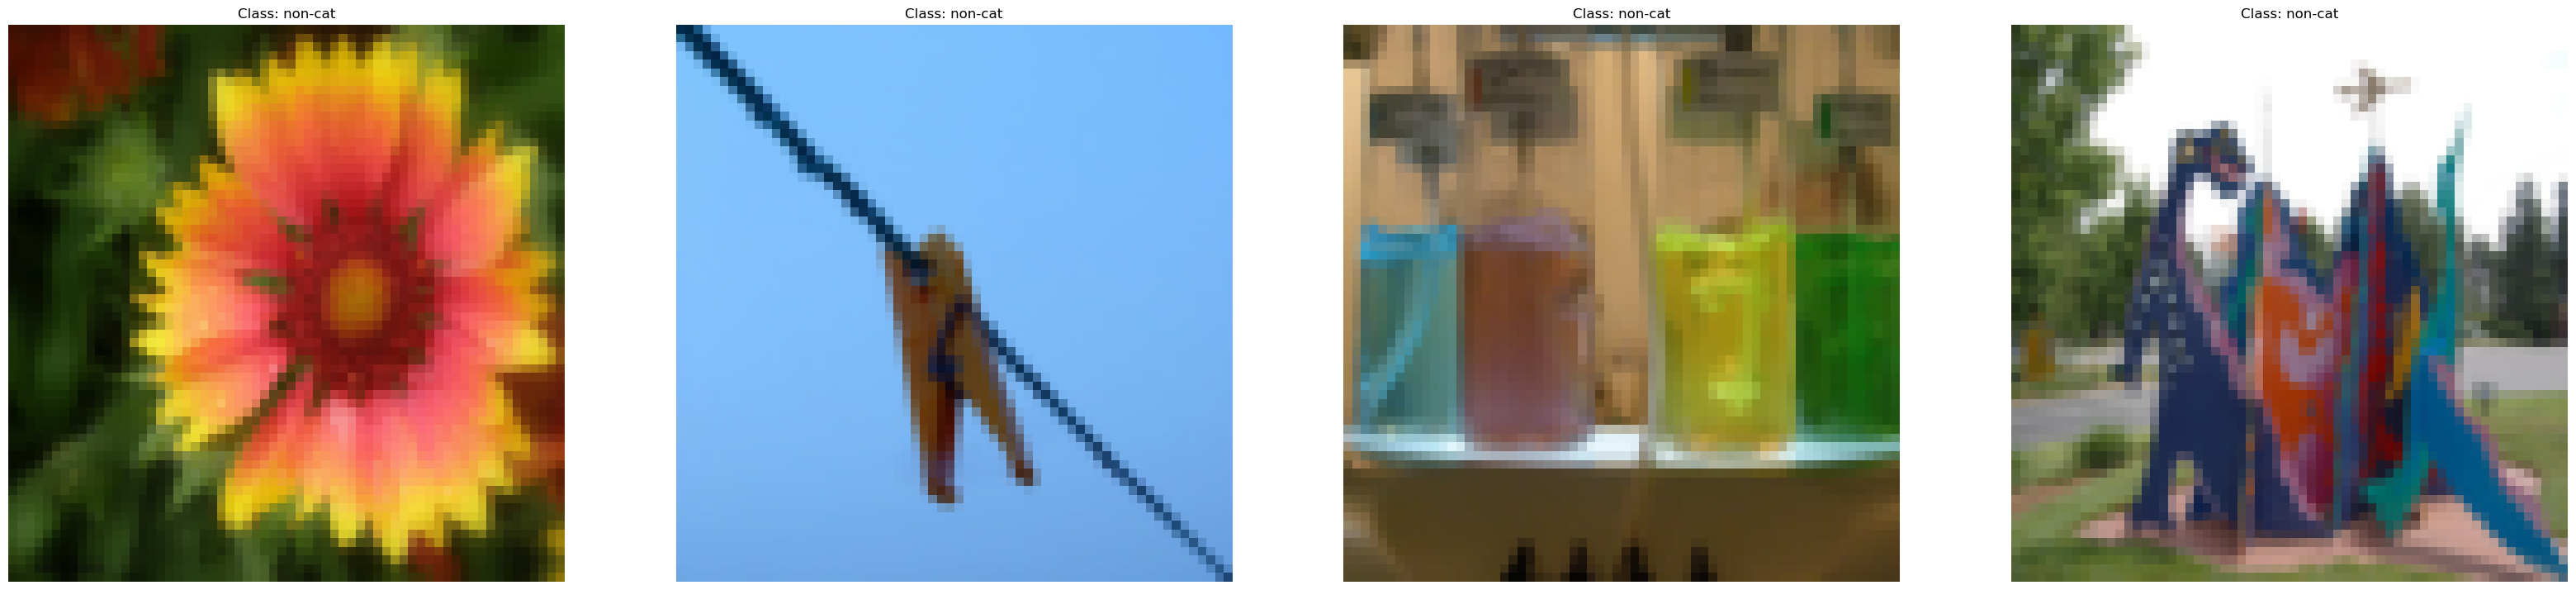

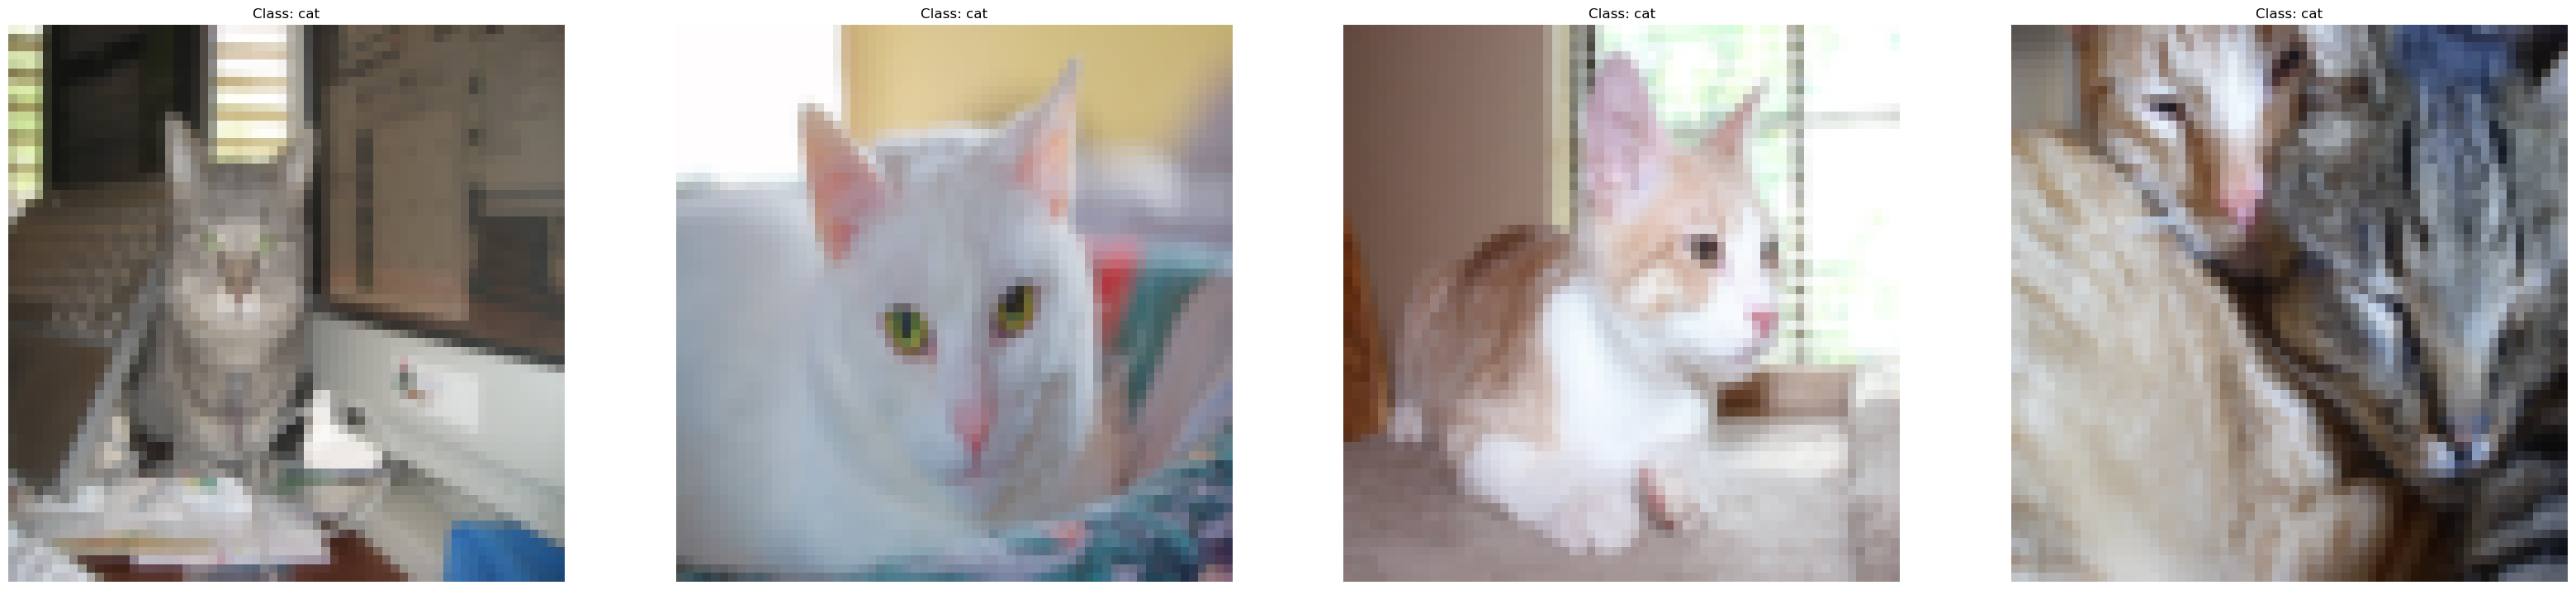

In [512]:
print_these_images(classes, train_neg_X_trade, train_neg_Y_trade) #negatives to be traded
print_these_images(classes, test_pos_X_trade, test_pos_Y_trade) #negatives to be traded

Cost after iteration 0: 0.7638637797361869
Cost after iteration 100: 0.6755950833336413
Cost after iteration 200: 0.6362590831861696
Cost after iteration 300: 0.6011204990353037
Cost after iteration 400: 0.5247205597361331
Cost after iteration 500: 0.47457702904804
Cost after iteration 600: 0.5251864006134884
Cost after iteration 700: 0.3641466675014006
Cost after iteration 800: 0.3339666238559355
Cost after iteration 900: 0.3864421398019986
Cost after iteration 1000: 0.23399073225359587
Cost after iteration 1100: 0.2059589734620208
Cost after iteration 1200: 0.1745155728841896
Cost after iteration 1300: 0.15386094009041135
Cost after iteration 1400: 0.13663744667528985
Cost after iteration 1500: 0.12371451378398926
Cost after iteration 1600: 0.11112055825024027
Cost after iteration 1700: 0.100365609045077
Cost after iteration 1800: 0.09098516024622819
Cost after iteration 1900: 0.08303705572516851
Cost after iteration 2000: 0.0767027886735676
Cost after iteration 2100: 0.0730916824468

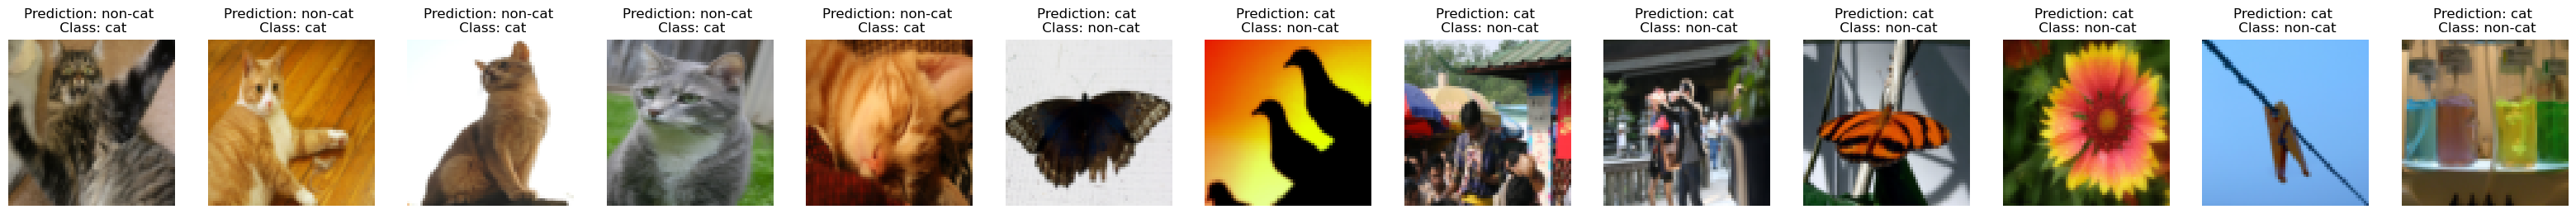

In [514]:
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model
parameters, costs = L_layer_model(bal_train_x, bal_train_y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=True)
bal_pred_train = predict(bal_train_x, bal_train_y, parameters)
bal_pred_test = predict(bal_test_x, bal_test_y, parameters)
print(f"positive samples: train = {np.sum(bal_train_y)}, test = {np.sum(bal_test_y)}")
print(f"bal_pred_test error count = {np.sum(bal_test_y != bal_pred_test)}")
print(f"bal_pred_test false negatives = {np.sum(bal_pred_test[bal_test_y == 1] == 0)}")
print(f"bal_pred_test false positives = {np.sum(bal_pred_test[bal_test_y == 0] == 1)}")
print_mislabeled_images(classes, bal_test_x, bal_test_y, bal_pred_test)

    So the results are indeed different with the same number traded and the new accuracy results are quite a bit worse. If you compare the mislabeled images with the “control” output with no changes to the dataset, you’ll see that all 7 of the false positives from the “control” run are still there, but we have two out of the newly added negatives traded in that are new false positives. So that accounts for the total of 9 false positives. But the false negatives make a lot less sense: one of the false negatives from “control” got traded, but the other one is still a false negative. But now we have three brand new false negatives. I’m sorry, but that just does not make sense to me: we gave the training algorithm more positives to learn from, but it does worse and flips 3 images that were correctly labeled as cats before (when it had fewer positive examples to train from) to being “non-cats”.

    So maybe the only conclusion here is that with a dataset this small, everything is highly sensitive to the smallest change and you don’t get any smoothing benefits from statistical effects. In other words, the fact that we get as good numbers as we do in the “control” version does say that they chose carefully. If we perturb the balance, we only get worse results. But there’s really probably not that much more to be learned here, since this is basically an unrealistic case. In the “meta” sense as well: too small to make generalizable conclusions. Well, maybe the right way to state the result is that the one generalizable conclusion from all this is that small datasets are a bummer.

##### References:

    For auto-reloading external module: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
    https://cs231n.github.io/neural-networks-3/#anneal
    https://github.com/dennybritz/nn-from-scratch
    https://cs231n.github.io/neural-networks-case-study/

In [244]:
### TESt CASES
#TEST CASES
def datatype_check(expected_output, target_output, error):
    success = 0
    if isinstance(target_output, dict):
        for key in expected_output.keys():
            try:
                success += datatype_check(expected_output[key], 
                                         target_output[key], error)
            except:
                print("Error: {} in variable {}. Got {} but expected type {}".format(error,
                                                                          key, type(target_output[key]), type(expected_output[key])))
        if success == len(target_output.keys()):
            return 1
        else:
            return 0
    elif isinstance(target_output, tuple) or isinstance(target_output, list):
        for i in range(len(expected_output)):
            try: 
                success += datatype_check(expected_output[i], 
                                         target_output[i], error)
            except:
                print("Error: {} in variable {}. Got type: {}  but expected type {}".format(error,
                                                                          i, type(target_output[i]), type(expected_output[i])))
        if success == len(target_output):
            return 1
        else:
            return 0
                
    else:
        assert isinstance(target_output, type(expected_output))
        return 1
            
def equation_output_check(expected_output, target_output, error):
    success = 0
    if isinstance(expected_output, dict):
        for key in expected_output.keys():
            try:
                success += equation_output_check(expected_output[key], 
                                         target_output[key], error)
            except:
                print("Error: {} for variable {}.".format(error,
                                                                          key))
        if success == len(target_output.keys()):
            return 1
        else:
            return 0
    elif isinstance(expected_output, tuple) or isinstance(expected_output, list):
        for i in range(len(expected_output)):
            try: 
                success += equation_output_check(expected_output[i], 
                                         target_output[i], error)
            except:
                print("Error: {} for variable {}.".format(error, i))
        if success == len(target_output):
            return 1
        else:
            return 0
                
    else:
        if hasattr(expected_output, 'shape'):
            #np.allclose(target_output, expected_output)
            np.testing.assert_array_almost_equal(target_output, expected_output)
        else:
            assert target_output == expected_output
        return 1
    
def shape_check(expected_output, target_output, error):
    success = 0
    if isinstance(expected_output, dict):
        for key in expected_output.keys():
            try:
                success += shape_check(expected_output[key], 
                                         target_output[key], error)
            except:
                print("Error: {} for variable {}.".format(error, key))
        if success == len(expected_output.keys()):
            return 1
        else:
            return 0
    elif isinstance(expected_output, tuple) or isinstance(expected_output, list):
        for i in range(len(expected_output)):
            try: 
                success += shape_check(expected_output[i], 
                                         target_output[i], error)
            except:
                print("Error: {} for variable {}.".format(error, i))
        if success == len(expected_output):
            return 1
        else:
            return 0
                
    else:
        if hasattr(expected_output, 'shape'):
            assert target_output.shape == expected_output.shape
        return 1

def multiple_test(test_cases, target):
    success = 0
    for test_case in test_cases:
        try:
            target_answer = target(*test_case['input'])                   
            if test_case['name'] == "datatype_check":
                success += datatype_check(test_case['expected'], target_answer, test_case['error'])
            if test_case['name'] == "equation_output_check":
                success += equation_output_check(test_case['expected'], target_answer, test_case['error'])
            if test_case['name'] == "shape_check":
                success += shape_check(test_case['expected'], target_answer, test_case['error'])
        except:
            print("Error: " + test_case['error'])
            
    if success == len(test_cases):
        print("\033[92m All tests passed.")
    else:
        print('\033[92m', success," Tests passed")
        print('\033[91m', len(test_cases) - success, " Tests failed")
        raise AssertionError("Not all tests were passed for {}. Check your equations and avoid using global variables inside the function.".format(target.__name__))

In [245]:
### UNIT TESTS
def two_layer_model_test(target):
    np.random.seed(1)
    n_x = 10
    n_h = 4
    n_y = 1
    num_examples = 10
    num_iterations = 2
    layers_dims = (n_x, n_h, n_y)
    learning_rate = 0.0075
    X = np.random.randn(n_x, num_examples)
    Y = np.random.randn(1, num_examples)
    
    expected_parameters = {'W1': np.array([[ 0.01624965, -0.00610741, -0.00528734, -0.01072836,  0.008664  ,
                                 -0.02301103,  0.01745639, -0.00760949,  0.0031934 , -0.00248971],
                                [ 0.01462848, -0.02057904, -0.00326745, -0.00383625,  0.01138176,
                                 -0.01097596, -0.00171974, -0.00877601,  0.00043022,  0.00584423],
                                [-0.01098272,  0.01148209,  0.00902102,  0.00500958,  0.00900571,
                                 -0.00683188, -0.00123491, -0.00937164, -0.00267157,  0.00532808],
                                [-0.00693465, -0.00400047, -0.00684685, -0.00844447, -0.00670397,
                                 -0.00014731, -0.01113977,  0.00238846,  0.0165895 ,  0.00738212]]),
                         'b1': np.array([[ 1.10437111e-05],
                                [ 1.78437869e-05],
                                [ 3.74879549e-05],
                                [-4.42988824e-05]]),
                         'W2': np.array([[-0.00200283, -0.00888593, -0.00751122,  0.01688162]]),
                         'b2': np.array([[-0.00689018]])}
    expected_costs = [np.array(0.69315968)]
    
    expected_output1 = (expected_parameters, expected_costs)
    
    expected_output2 = ({'W1': np.array([[ 0.01640028, -0.00585699, -0.00542633, -0.01069332,  0.0089055 ,
        -0.02290418,  0.01765388, -0.00754616,  0.00326712, -0.00239159],
       [ 0.01476737, -0.02014461, -0.0040947 , -0.0037457 ,  0.01221714,
        -0.01054049, -0.00164111, -0.00872507,  0.00058592,  0.00615077],
       [-0.01051621,  0.01216499,  0.009119  ,  0.0047126 ,  0.00894761,
        -0.00672568, -0.00134921, -0.0096428 , -0.00253223,  0.00580758],
       [-0.00728552, -0.00461461, -0.00638113, -0.00831084, -0.00654136,
        -0.00053186, -0.01052771,  0.00320719,  0.01643914,  0.00667123]]), 
       'b1': np.array([[ 0.00027478],
       [ 0.00034477],
       [ 0.00076016],
       [-0.00084497]]), 
       'W2': np.array([[-0.00358725, -0.00911995, -0.00831979,  0.01615845]]), 
       'b2': np.array([[-0.13451354]])}, [np.array(0.69315968)])
    
    test_cases = [
        {
            "name":"datatype_check",
            "input": [X, Y, layers_dims, learning_rate, num_iterations],
            "expected": expected_output1,
            "error":"Datatype mismatch."
        },
        {
            "name": "shape_check",
            "input": [X, Y, layers_dims, learning_rate, num_iterations],
            "expected": expected_output1,
            "error": "Wrong shape"
        },
        {
            "name": "equation_output_check",
            "input": [X, Y, layers_dims, learning_rate, num_iterations],
            "expected": expected_output1,
            "error": "Wrong output"
        },
        {
            "name": "equation_output_check",
            "input": [X, Y, layers_dims, 0.1, 3],
            "expected": expected_output2,
            "error": "Wrong output"
        }
    ]
    
    multiple_test(test_cases, target)
    
two_layer_model_test(two_layer_model)

Cost after iteration 1: 0.6915746967050505
Cost after iteration 1: 0.6915746967050505
Cost after iteration 1: 0.6915746967050505
Cost after iteration 2: 0.6524135179683451
 All tests passed.


In [246]:
def L_layer_model_test(target):
    np.random.seed(1)
    n_x = 10 
    n_y = 1
    num_examples = 10
    num_iterations = 2
    layers_dims = (n_x, 5, 6 , n_y)
    learning_rate = 0.0075
    X = np.random.randn(n_x, num_examples)
    Y = np.array([1,1,1,1,0,0,0,1,1,0]).reshape(1,10)
    
    expected_parameters = {'W1': np.array([[ 0.51384638, -0.19333098, -0.16705238, -0.33923196,  0.273477  ,
         -0.72775498,  0.55170785, -0.24077478,  0.10082452, -0.07882423],
        [ 0.46227786, -0.65153639, -0.10192959, -0.12150984,  0.35855025,
         -0.34787253, -0.05455001, -0.27767163,  0.01337835,  0.1843845 ],
        [-0.34790478,  0.36200264,  0.28511245,  0.15868454,  0.284931  ,
         -0.21645471, -0.03877896, -0.29584578, -0.08480802,  0.16760667],
        [-0.21835973, -0.12531366, -0.21720823, -0.26764975, -0.21214946,
         -0.00438229, -0.35316347,  0.07432144,  0.52474685,  0.23453653],
        [-0.06060968, -0.28061463, -0.23624839,  0.53526844,  0.01597194,
         -0.20136496,  0.06021639,  0.66414167,  0.03804666,  0.19528599]]),
 'b1': np.array([[-2.16491028e-04],
        [ 1.50999130e-04],
        [ 8.71516045e-06],
        [ 5.57557615e-05],
        [-2.90746349e-05]]),
 'W2': np.array([[ 0.13428358, -0.15747685, -0.51095667, -0.15624083, -0.09342034],
        [ 0.26226685,  0.3751336 ,  0.41644174,  0.12779375,  0.39573817],
        [-0.33726917,  0.56041154,  0.22939257, -0.1333337 ,  0.21851314],
        [-0.03377599,  0.50617255,  0.67960046,  0.97726521, -0.62458844],
        [-0.64581803, -0.22559264,  0.0715349 ,  0.39173682,  0.14112904],
        [-0.9043503 , -0.13693179,  0.37026002,  0.10284282,  0.34076545]]),
 'b2': np.array([[ 1.80215514e-07],
        [-1.07935097e-04],
        [ 1.63081605e-04],
        [-3.51202008e-05],
        [-7.40012619e-05],
        [-4.43814901e-05]]),
 'W3': np.array([[-0.09079199, -0.08117381,  0.07667568,  0.16665535,  0.08029575,
          0.04805811]]),
 'b3': np.array([[0.0013201]])}
    expected_costs = [np.array(0.70723944)]
    
    expected_output1 = (expected_parameters, expected_costs)
    expected_output2 = ({'W1': np.array([[ 0.51439065, -0.19296367, -0.16714033, -0.33902173,  0.27291558,
                -0.72759069,  0.55155832, -0.24095201,  0.10063293, -0.07872596],
               [ 0.46203186, -0.65172685, -0.10184775, -0.12169458,  0.35861847,
                -0.34804029, -0.05461748, -0.27787524,  0.01346693,  0.18463095],
               [-0.34748255,  0.36202977,  0.28512463,  0.1580327 ,  0.28509518,
                -0.21717447, -0.03853304, -0.29563725, -0.08509025,  0.16728901],
               [-0.21727997, -0.12486465, -0.21692552, -0.26875722, -0.21180188,
                -0.00550575, -0.35268367,  0.07489501,  0.52436384,  0.23418418],
               [-0.06045008, -0.28038304, -0.23617868,  0.53546925,  0.01569291,
                -0.20115358,  0.05975429,  0.66409149,  0.03819309,  0.1956102 ]]), 
                         'b1': np.array([[-8.61228305e-04],
               [ 6.08187689e-04],
               [ 3.53075377e-05],
               [ 2.21291877e-04],
               [-1.13591429e-04]]), 
                         'W2': np.array([[ 0.13441428, -0.15731437, -0.51097778, -0.15627102, -0.09342034],
               [ 0.2620349 ,  0.37492336,  0.4165605 ,  0.12801536,  0.39541677],
               [-0.33694339,  0.56075022,  0.22940292, -0.1334017 ,  0.21863717],
               [-0.03371679,  0.50644769,  0.67935577,  0.97680859, -0.62475679],
               [-0.64579072, -0.22555897,  0.07142896,  0.3914475 ,  0.14104814],
               [-0.90433399, -0.13691167,  0.37019673,  0.10266999,  0.34071712]]), 
                         'b2': np.array([[ 1.18811550e-06],
               [-4.25510194e-04],
               [ 6.56178455e-04],
               [-1.42335482e-04],
               [-2.93618626e-04],
               [-1.75573157e-04]]), 
                         'W3': np.array([[-0.09087434, -0.07882982,  0.07821609,  0.16442826,  0.0783229 ,
                 0.04648216]]), 
                         'b3': np.array([[0.00525865]])}, [np.array(0.70723944)])
    
    test_cases = [
        {
            "name": "equation_output_check",
            "input": [X, Y, layers_dims, learning_rate, num_iterations],
            "expected": expected_output1,
            "error": "Wrong output"
        },
        {
            "name":"datatype_check",
            "input": [X, Y, layers_dims, learning_rate, num_iterations],
            "expected": expected_output1,
            "error":"Datatype mismatch."
        },
        {
            "name": "shape_check",
            "input": [X, Y, layers_dims, learning_rate, num_iterations],
            "expected": expected_output1,
            "error": "Wrong shape"
        },
        {
            "name": "equation_output_check",
            "input": [X, Y, layers_dims, 0.02, 3],
            "expected": expected_output2,
            "error": "Wrong output"
        },
    ]
    
    multiple_test(test_cases, target)
    
L_layer_model_test(L_layer_model)

Cost after iteration 1: 0.7070709008912568
Cost after iteration 1: 0.7070709008912568
Cost after iteration 1: 0.7070709008912568
Cost after iteration 2: 0.7063462654190896
 All tests passed.


Cost after iteration 0: 0.6930497356599891
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912678
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605748
Cost after iteration 500: 0.515830477276473
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.400797753620389
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.3052753636196264
Cost after iteration 1200: 0.2749137728213018
Cost after iteration 1300: 0.2468176821061484
Cost after iteration 1400: 0.1985073503746609
Cost after iteration 1500: 0.17448318112556668
Cost after iteration 1600: 0.1708076297809595
Cost after iteration 1700: 0.11306524562164735
Cost after iteration 1800: 0.09629426845937153
Cost after iteration 1900: 0.08342617959726857
Cost after iteration 2000: 0.07439078704319083
Cost after iteration 2100: 0.06630748132267

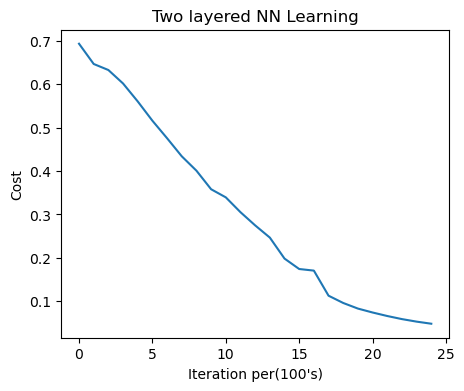

Training Accuracy: 0.9999999999999998


In [375]:
#Self Practice
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import h5py
%matplotlib inline
np.random.seed(1)

plt.rcParams["figure.figsize"] = (5.0, 4.0)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

#2 Layer Model

#load data
def load_data():
    train_data = h5py.File("./data/train_catvnoncat.h5", "r")
    test_data = h5py.File("./data/test_catvnoncat.h5", "r")
    
    train_X_orig = np.array(train_data["train_set_x"])
    train_Y_orig = np.array(train_data["train_set_y"])
    
    test_X_orig = np.array(test_data["test_set_x"])
    test_Y_orig = np.array(test_data["test_set_y"])
    classes = np.array(test_data["list_classes"])
    
    return train_X_orig, train_Y_orig, test_X_orig, test_Y_orig, classes

#intialiaze params
def initialize_parameters(layer_dims):
    np.random.seed(1)
    n_x, n_h, n_y = layer_dims
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    params = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return params

#Forward Propagation
def linear_forward(W_l, b_l, A_prev):
    Z_l = np.dot(W_l, A_prev) + b_l
    cache = (A_prev, W_l, b_l)
    return Z_l, cache

def sigmoid(Z):
    g = 1 / (1 + np.exp(-Z))
    activation_cache = Z
    return g, activation_cache

def relu(Z):
    g = np.maximum(0, Z)
    activation_cache = Z
    return g, activation_cache

def linear_activation_forward(Z, activation_name="relu"):
    if activation_name == "sigmoid":
        A, activation_cache = sigmoid(Z)
        return A, activation_cache
    A, activation_cache = relu(Z)
    return A, activation_cache

def two_layer_forward(X, params):
    W1, b1, W2, b2 = params.values()
    A0 = X
    caches = []
    
    #first layer
    Z1, linear_cache = linear_forward(W1, b1, A0)
    A1, activation_cache = linear_activation_forward(Z1)
    cache = (linear_cache, activation_cache)
    caches.append(cache)
    
    #second layer
    Z2, linear_cache = linear_forward(W2, b2, A1)
    A2, activation_cache = linear_activation_forward(Z2, activation_name="sigmoid")
    cache = (linear_cache, activation_cache)
    caches.append(cache)
    
    return A2, caches

#Cost
def compute_cost(A2, Y):
    m = Y.shape[1]
    cost = - (np.dot(Y, np.log(A2.T)) + np.dot(1-Y, np.log(1-A2.T))) / m
    cost = np.squeeze(cost)
    return cost

#backward propagation
def sigmoid_backward(Z):
    A, _ = sigmoid(Z)
    g_d = A * (1 - A)
    return g_d

def relu_backward(Z):
    g_d = np.where(Z > 0, 1, 0)
    return g_d


def linear_backward(dA_l, m, linear_cache, activation_cache, activation_name="relu"):
    Z_l = activation_cache
    if activation_name == "sigmoid":
        g_d_l = sigmoid_backward(Z_l)
        dZ_l = dA_l *  g_d_l
    else:
        g_d_l = relu_backward(Z_l)
        dZ_l = dA_l *  g_d_l
        
    #derivatives that uses dZ_l
    A_prev, W_l, b_l = linear_cache
    dW_l = (1 / m) * np.dot(dZ_l, A_prev.T)
    db_l = (1 / m) * np.sum(dZ_l, axis=1, keepdims=True)
    dA_prev = np.dot(W_l.T, dZ_l) #for hidden layer, here we are calculating dA0, which is actually not needed
    return dW_l, db_l, dA_prev


def linear_activation_backward(A2, Y, caches):
    grads = {}
    m = Y.shape[1]
    #output layer
    dA2 = -(np.divide(Y, A2) - np.divide(1-Y, 1-A2))
    
    linear_cache, activation_cache = caches[-1]
    dW2, db2, dA1 = linear_backward(dA2, m, linear_cache, activation_cache, activation_name="sigmoid")
    
    #hidden layer
    linear_cache, activation_cache = caches[0]
    dW1, db1, _ = linear_backward(dA1, m, linear_cache, activation_cache)
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}       
    return grads


def two_layer_backward(A2, Y, caches):
#     dA2, dZ2, dW2, db2, dA1, dZ1, dW1, db1, dA0(not needed)
    Y = Y.reshape(A2.shape)
    grads = linear_activation_backward(A2, Y, caches)
    return grads

#optimization
def update_params(params, grads, learning_rate):
    W1, b1, W2, b2 = params.values()
    dW1, db1, dW2, db2 = grads.values()
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    params = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return params  

#model
def two_layer_model(X, Y, layer_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    np.random.seed(1)
    #initialize params
    params = initialize_parameters(layer_dims)
    costs = []
    #gradient descent algorithm
    for i in range(num_iterations):
        A2, caches = two_layer_forward(X, params)
        cost = compute_cost(A2, Y)
        grads = two_layer_backward(A2, Y, caches)
        params = update_params(params, grads, learning_rate)
        if print_cost and i % 100 == 0 or i == num_iterations-1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    return params, costs
            

#plot
def plot_learning_curve(costs):
    plt.plot(np.squeeze(costs), label="Cost")
    plt.xlabel("Iteration per(100's)")
    plt.ylabel("Cost")
    plt.title("Two layered NN Learning")
    plt.show()

#predict
def predict(X, params):
    A2, _ = two_layer_forward(X, params)
    preds = (A2 > 0.5).astype(int)
    return preds

#Data
train_X_orig, train_Y_orig, test_X_orig, test_Y_orig, classes = load_data() 

train_X = train_X_orig.reshape(train_X_orig.shape[0], -1).T
test_X = test_X_orig.reshape(test_X_orig.shape[0], -1).T
train_X = train_X / 255.0
test_X = test_X / 255.0
train_Y = train_Y_orig.reshape(1, -1)
test_Y = test_Y_orig.reshape(1, -1)
 

#Building Network hyperparameters
n_x = train_X.shape[0]
n_h = 7
n_y = train_Y.shape[0]
layer_dims = (n_x, n_h, n_y)

#Traning
final_params, costs = two_layer_model(train_X, train_Y, layer_dims, num_iterations=2500, print_cost=True)

#plotting the learning curve
plot_learning_curve(costs)

#predictions
train_preds = predict(train_X, final_params)

m = train_Y.shape[1]
print("Training Accuracy: "  + str(np.sum((train_preds == train_Y)/m)))

In [376]:
#predictions
test_preds = predict(test_X, final_params)

m = test_Y.shape[1]
print("Test Accuracy: "  + str(np.sum((test_preds == test_Y)/m)))

Test Accuracy: 0.72


Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6720534400822913
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101354
Cost after iteration 400: 0.5670473268366111
Cost after iteration 500: 0.54013766345478
Cost after iteration 600: 0.5279299569455267
Cost after iteration 700: 0.4654773771766852
Cost after iteration 800: 0.369125852495928
Cost after iteration 900: 0.3917469743480534
Cost after iteration 1000: 0.3151869888600617
Cost after iteration 1100: 0.2726998441789386
Cost after iteration 1200: 0.23741853400268134
Cost after iteration 1300: 0.19960120532208644
Cost after iteration 1400: 0.18926300388463305
Cost after iteration 1500: 0.1611885466582775
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.13777487812972944
Cost after iteration 1800: 0.1297401754919012
Cost after iteration 1900: 0.12122535068005214
Cost after iteration 2000: 0.11382060668633712
Cost after iteration 2100: 0.1078392852625

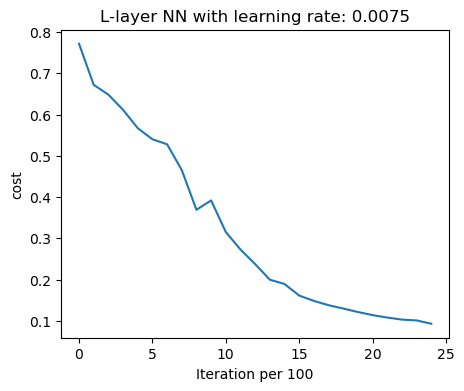

In [436]:
#L Layer Model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import h5py
%matplotlib inline
np.random.seed(1)

plt.rcParams["figure.figsize"] = (5.0, 4.0)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"


#load data
def load_data():
    train_data = h5py.File("./data/train_catvnoncat.h5", "r")
    test_data = h5py.File("./data/test_catvnoncat.h5", "r")
    
    train_X_orig = np.array(train_data["train_set_x"])
    train_X_flatten = train_X_orig.reshape(train_X_orig.shape[0], -1).T
    train_X = train_X_flatten / 255.0
    
    train_Y_orig = np.array(train_data["train_set_y"])
    train_Y = train_Y_orig.reshape(1, -1)
    
    test_X_orig = np.array(test_data["test_set_x"])
    test_X_flatten = test_X_orig.reshape(test_X_orig.shape[0], -1).T
    test_X = test_X_flatten / 255.0
    
    test_Y_orig = np.array(test_data["test_set_y"])
    test_Y = test_Y_orig.reshape(1, -1)
    
    classes = np.array(test_data["list_classes"])
    
    return train_X, train_Y, test_X, test_Y, classes

#intialiaze params
def initialize_parameters(layer_dims):
    np.random.seed(1)
    L = len(layer_dims)
    params = {}
    for l in range(1, L):
        params["W"+str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        params["b"+str(l)] = np.zeros((layer_dims[l], 1))    
    return params

#Forward Propagation
def linear_forward(A_prev, W_l, b_l):
    Z_l = np.dot(W_l, A_prev) + b_l
    linear_cache = (A_prev, W_l, b_l)
    return Z_l, linear_cache 

def sigmoid(Z):
    g_Z = 1 / (1 + np.exp(-Z))
    activation_cache = Z
    return g_Z, activation_cache

def relu(Z):
    g_Z = np.maximum(0, Z)
    activation_cache = Z
    return g_Z, activation_cache

def linear_activation_forward(Z_l, activation_name="relu"):
    if activation_name == "sigmoid":
        A_l, activation_cache = sigmoid(Z_l)
        return A_l, activation_cache
    A_l, activation_cache = relu(Z_l)
    return A_l, activation_cache
    

def L_layers_forward(X, params):
    L = len(params) // 2
    caches = []
    A_prev = X
    for l in range(1, L):
        Z_l, linear_cache = linear_forward(A_prev, params[f"W{l}"], params[f"b{l}"])
        A_l, activation_cache = linear_activation_forward(Z_l, activation_name="relu")
        A_prev = A_l
        cache = (linear_cache, activation_cache)
        caches.append(cache)
        
    Z_L, linear_cache = linear_forward(A_prev, params[f"W{L}"], params[f"b{L}"])
    AL, activation_cache = linear_activation_forward(Z_L, activation_name="sigmoid")
    cache = (linear_cache, activation_cache)
    caches.append(cache)
    return AL, caches 
        

#cost
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = - (np.sum((Y * np.log(AL)) + ((1-Y) * np.log(1-AL)))) / m
    cost = np.squeeze(cost)
    return cost

#backward propagation
def sigmoid_backward(dA_l, Z_l):
    A_l, _ = sigmoid(Z_l)
    g_d_Z = A_l * (1 - A_l)
    dZ_l = dA_l * g_d_Z
    return dZ_l

def relu_backward(dA_l, Z_l):
    dZ_l = np.array(dA_l, copy=True)
    dZ_l[Z_l <= 0] = 0
    return dZ_l

def linear_backward(dA_l, activation_cache, activation_name):
    Z_l = activation_cache
    if activation_name == "sigmoid":
        dZ_l = sigmoid_backward(dA_l, Z_l)
        return dZ_l
    dZ_l = relu_backward(dA_l, Z_l)
    return dZ_l


def linear_activation_backward(dA_l, current_cache, activation_name="relu"):
    linear_cache, activation_cache = current_cache
    dZ_l = linear_backward(dA_l, activation_cache, activation_name)
    A_prev, W_l, b_l = linear_cache
    m = A_prev.shape[1]
    dW_l = (1/m) * np.dot(dZ_l, A_prev.T)
    db_l = (1/m) * np.sum(dZ_l, axis=1, keepdims=1)
    dA_prev = np.dot(W_l.T, dZ_l)
    return dW_l, db_l, dA_prev
    

def L_layers_backward(AL, Y, caches):
    L = len(caches)
    grads = {}
    Y = Y.reshape(AL.shape)
    
    #Output layer
    dAL = - (np.divide(Y, AL) - np.divide(1-Y, 1-AL)) #initialize backprop
    current_cache = caches[L-1] #last layer cache
    dW_l, db_l, dA_prev = linear_activation_backward(dAL, current_cache, activation_name="sigmoid")
    grads[f"dW{L}"] = dW_l
    grads[f"db{L}"] = db_l
    
    
    #remaining layers (L-2)
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dW_l, db_l, dA_prev = linear_activation_backward(dA_prev, current_cache)
        grads[f"dW{l+1}"] = dW_l
        grads[f"db{l+1}"] = db_l
    
    return grads

#optimization
def update_params(params, grads, learning_rate):
    L = len(params) // 2
    for l in range(L):
        params[f"W{l+1}"] -= learning_rate *  grads[f"dW{l+1}"]
        params[f"b{l+1}"] -= learning_rate *  grads[f"db{l+1}"]
    return params   

#model
def L_layers_model(X, Y, layer_dims, learning_rate=0.0075, num_iters=3000, print_cost=False):
    costs = []
    params = initialize_parameters(layer_dims)
    grads = {}
    
    for i in range(num_iters):
        AL, caches = L_layers_forward(X, params)
        cost = compute_cost(AL, Y)
        grads = L_layers_backward(AL, Y, caches)
        params = update_params(params, grads, learning_rate)
        
        if print_cost and i % 100 == 0 or i == num_iters - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iters:
            costs.append(cost)
        
    return params, costs

#plot
def plot_learning(costs, learning_rate=0.0075): 
    plt.plot(np.squeeze(costs))
    plt.xlabel("Iteration per 100")
    plt.ylabel("cost")
    plt.title(f"L-layer NN with learning rate: {learning_rate}")
    plt.show()

#predict
def predict(X, params):
    probs, _ = L_layers_forward(X, params)
    preds = (probs > 0.5).astype(int)
    return preds

#Data
layer_dims = [12288, 20, 7, 5, 1]
train_X, train_Y, test_X, test_Y, classes = load_data()

#Training
params, costs = L_layers_model(train_X, train_Y, layer_dims, learning_rate=0.0075, num_iters=2500, print_cost=True)

#predictions
train_preds = predict(train_X, params)
m = train_Y.shape[1]
print(f"Training accuracy: {np.sum(train_preds==train_Y) / m}")

plot_learning(costs)

In [380]:
#Test accuracy
test_preds = predict(test_X, params)

m = test_Y.shape[1]
print("Test Accuracy: "  + str(np.sum((test_preds == test_Y)/m)))

Test Accuracy: 0.8


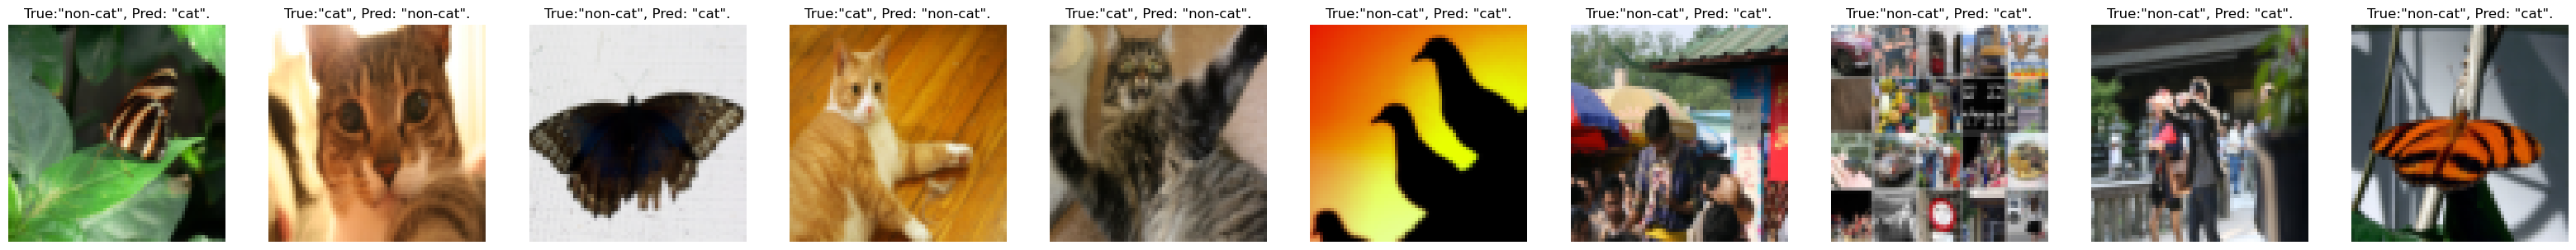

In [403]:
#Print mislabelled images
# print(test_preds != test_Y)
# mislabelled = test_X[:, np.squeeze(test_preds != test_Y)]
# print(mislabelled.shape)
# print(len(mislabelled))
# print(len(mislabelled[0]))

mislabelled_idxs = np.asarray(np.where(test_preds != test_Y))
num_px = 64

# print(mislabelled_idxs)
# print(mislabelled_idxs.shape)
# print(mislabelled_idxs.shape[1])
plt.rcParams["figure.figsize"] = (40, 40)
num_images = mislabelled_idxs.shape[1]
for i in range(num_images):
    idx = mislabelled_idxs[1][i]
    plt.subplot(2, num_images, i+1) #n_rows, n_cols, index position
    plt.imshow(test_X[:, idx].reshape(num_px, num_px, 3))
    plt.title("True:\""+classes[int(test_Y[0, idx])].decode("utf-8")  + "\", Pred: \""+classes[test_preds[0, idx]].decode("utf-8") +"\".")
    plt.axis("off")
plt.show()

(64, 64, 3)
(12288, 1)
Y is: "non-cat" and, L-layer model predicted it as "non-cat".


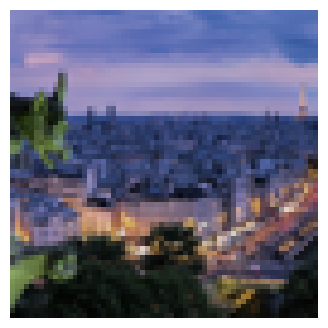

In [416]:
#Prediction of own image
image = "./images/gargouille.jpg"
num_px = 64
myimage = np.asarray(Image.open(image).resize((num_px, num_px)))
mylabel_y = [0]
print(myimage.shape)

#reshape and standardize
myimage_flattened = myimage.reshape(1, -1).T
myimage_scaled = myimage_flattened / 255.0

print(myimage_scaled.shape)

#Prediction
mypred = predict(myimage_scaled, params)
print("Y is: \""+classes[int(np.squeeze(mylabel_y))].decode("utf-8")+"\" and, L-layer model predicted it as \""+
     classes[int(np.squeeze(mypred))].decode("utf-8")+"\".")
plt.rcParams["figure.figsize"] = (5.0, 4.0)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"
plt.imshow(myimage)
plt.axis("off")
plt.show()

In [417]:
list(range(3))

[0, 1, 2]

In [442]:
a = np.array([[1, 1, 1], [1, 1, 1]])
b = np.array([1, 2, 6])
np.dot(a, b)

array([9, 9])